In [1]:
import polars as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from itertools import chain, combinations
import os
import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [2]:
def parse_datetime(dt_string):
    return datetime.datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S")

In [3]:
"""
curr_webget.csv	    Web browsing performance
unit_id	            Unique identifier for an individual unit
dtime	            Time test finished in local time
ddate           	Date test finished in local time
target          	URL to fetch
address         	IP address connected to to fetch content from initial URL
fetch_time	        Sum of time consumed to download Html content and then concurrently download all resources (Units: micorsecounds)
bytes_total	        Sum of HTML content size and all resources size (Units : Bytes)
bytes_sec	        Average speed of downloading HTML content and then concurrently downloading all resources (Units: bytes/sec)
objects	            Number of Resources (images, css etc) downloaded
threads	            Maximum number of concurrent threads allowed
requests        	Total number of HTTP requests made
connections	        Total number of TCP connections established
reused_connections	Number of TCP connections re-used
lookups	            Number of DNS lookups performed
request_total_time	Total duration of all requests summed together, if made sequentially
request_min_time	Shortest request duration
request_avg_time	Average request duration
request_max_time	Longest request duration
ttfb_total_time	    Total duration of the time-to-first-byte summed together, if made sequentially
ttfb_min_time	    Shortest time-to-first-byte duration
ttfb_avg_time	    Average time-to-first-byte duration
ttfb_max_time	    Longest time-to-first-byte duration
lookup_total_time	Total duration of all DNS lookups summed together, if made sequentially
lookup_min_time	    Shortest DNS lookup duration
lookup_avg_time	    Average DNS lookup duration
lookup_max_time	    Longest DNS lookup duration
successes	        Number of successes
failures	        Number of failures
"""
webget_df = pd.read_csv("validated-data-sept2022/curr_webget.csv")
units_df = pd.read_csv("validated-data-sept2022/unit-profile-sept2022.csv", infer_schema_length=10000)

webget_df.describe()

statistic,unit_id,dtime,ddate,target,address,fetch_time,bytes_total,bytes_sec,objects,threads,requests,connections,reused_connections,lookups,request_total_time,request_min_time,request_avg_time,request_max_time,ttfb_total,ttfb_min,ttfb_avg,ttfb_max,lookup_total_time,lookup_min_time,lookup_avg_time,lookup_max_time,successes,failures
str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.327612e6,"""4327612""","""4327612""","""4327612""","""4327612""",4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6
"""null_count""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.4338e7,null,null,null,null,2.2859e6,2.0661e6,1.1489e6,19.957516,8.0,19.787458,12.432393,7.355064,3.481104,1.8263e7,115609.234235,696684.13436,1.4856e6,4.9567e6,159277.292556,326257.268254,574591.035329,253811.156258,60949.210609,74142.490398,101748.248337,1.0,0.0
"""std""",2.8041e7,null,null,null,null,3.1656e6,1.6833e6,1.0237e6,19.824713,0.0,19.737505,10.245468,10.857861,2.747289,3.3654e7,230594.956134,1.0111e6,2.4256e6,7.7581e6,160551.232564,462954.782726,879151.157296,1.7670e6,440834.54781,463903.742526,591265.725205,0.0,0.0
"""min""",447.0,"""2022-09-12 00:00:00""","""2022-09-12""","""http://edition.cnn.com/""","""1.1.1.6""",50000.0,51.0,15.0,1.0,8.0,1.0,1.0,0.0,1.0,1699.0,1699.0,1699.0,1699.0,1450.0,1450.0,1450.0,1450.0,-355559.0,-355559.0,-355559.0,-355559.0,1.0,0.0
"""25%""",3.898153e6,null,null,null,null,954696.0,220751.0,469677.0,3.0,8.0,3.0,3.0,0.0,1.0,1.058055e6,40456.0,280477.0,485395.0,718292.0,78235.0,155441.0,180289.0,26594.0,13551.0,16997.0,19424.0,1.0,0.0
"""50%""",3.5318429e7,null,null,null,null,1.594972e6,1.750606e6,817013.0,10.0,8.0,10.0,9.0,1.0,2.0,7.197212e6,68771.0,457380.0,929972.0,2.92845e6,136351.0,266945.0,388068.0,59683.0,21323.0,24826.0,28439.0,1.0,0.0
"""75%""",5.5518713e7,null,null,null,null,2.438486e6,2.81123e6,1.679305e6,31.0,8.0,31.0,24.0,8.0,5.0,1.9703949e7,138824.0,769936.0,1.467366e6,6.883532e6,198300.0,343850.0,591039.0,141364.0,30862.0,36548.0,46710.0,1.0,0.0
"""max""",8.2211365e7,"""2022-10-31 23:59:59""","""2022-10-31""","""http://www.msn.com/""","""99.86.5.87""",2.99997e7,4.721411e6,4.439553e6,200.0,8.0,200.0,40.0,182.0,11.0,1.6356e9,2.9809013e7,2.9809013e7,2.9809013e7,1.82700264e8,2.4523762e7,2.4523762e7,2.8816155e7,8.0266808e7,2.8905621e7,2.8905621e7,2.8905621e7,1.0,0.0


In [4]:
webget_df_ts = webget_df.join(
    units_df, left_on="unit_id", right_on="Unit ID", how="left"
)

webget_df_ts = webget_df_ts.with_columns(
    pd.col("dtime")
        .map_elements(lambda dt: parse_datetime(dt).timestamp())
        .alias("ts_start")
).with_columns(
    (pd.col("ts_start") - pd.col("timezone_offset") * 3600).alias("ts_start")
).with_columns(
    (pd.col("ts_start") + pd.col("request_total_time") / 1000_000).alias("ts_end")
)
webget_df_ts

/var/folders/t7/vs_g77jx593d4x161y_zfvwc0000gn/T/ipykernel_63938/2396100059.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  webget_df_ts = webget_df_ts.with_columns(


unit_id,dtime,ddate,target,address,fetch_time,bytes_total,bytes_sec,objects,threads,requests,connections,reused_connections,lookups,request_total_time,request_min_time,request_avg_time,request_max_time,ttfb_total,ttfb_min,ttfb_avg,ttfb_max,lookup_total_time,lookup_min_time,lookup_avg_time,lookup_max_time,successes,failures,ISP,Technology,State,Census,timezone_offset,timezone_offset_dst,Download,Upload,Whitebox Model,ts_start,ts_end
i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,i64,i64,f64,f64,str,f64,f64
41088977,"""2022-10-25 05:17:19""","""2022-10-25""","""http://www.google.com/policies…","""172.217.5.4""",502580,1349,2684,1,8,1,1,0,1,52759,52759,52759,52759,52358,52358,52358,52358,448874,448874,448874,448874,1,0,"""Frontier""","""DSL""","""OH""","""Midwest""",-5,-4,12.0,0.512,"""skwb8""",1.6667e9,1.6667e9
56315053,"""2022-10-30 05:58:37""","""2022-10-30""","""http://www.google.com/policies…","""172.217.5.4""",196295,1349,6872,1,8,1,1,0,1,134901,134901,134901,134901,133713,133713,133713,133713,60375,60375,60375,60375,1,0,"""CenturyLink""","""DSL""","""PA""","""Northeast""",-5,-4,7.0,0.512,"""skwb8""",1.6671e9,1.6671e9
40730241,"""2022-10-29 05:43:11""","""2022-10-29""","""http://www.google.com/policies…","""172.217.5.4""",127696,1349,10564,1,8,1,1,0,1,106345,106345,106345,106345,105779,105779,105779,105779,20325,20325,20325,20325,1,0,"""CenturyLink""","""DSL""","""KS""","""Midwest""",-6,-5,25.0,2.0,"""skwb8""",1.6670e9,1.6670e9
50156861,"""2022-10-24 19:53:26""","""2022-10-24""","""http://www.google.com/policies…","""172.217.5.4""",117890,1349,11442,1,8,1,1,0,1,113307,113307,113307,113307,108665,108665,108665,108665,3700,3700,3700,3700,1,0,"""CenturyLink""","""DSL""","""OH""","""Midwest""",-5,-4,1.5,0.512,"""skwb8""",1.6666e9,1.6666e9
3952881,"""2022-09-13 09:36:42""","""2022-09-13""","""http://www.google.com/policies…","""172.217.5.4""",100969,1349,13360,1,8,1,1,0,1,70110,70110,70110,70110,69795,69795,69795,69795,29762,29762,29762,29762,1,0,"""Mediacom""","""Cable""","""MO""","""Midwest""",-6,-5,400.0,30.0,"""skwb8""",1.6631e9,1.6631e9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
80213805,"""2022-10-25 13:37:34""","""2022-10-25""","""http://www.ebay.com/""","""173.223.157.48""",2109750,1880074,891135,64,8,64,34,30,3,57559515,19213,899367,1507029,6901060,115754,202972,337089,50114,14697,16704,18288,1,0,"""Windstream""","""DSL""","""TX""","""South""",-6,-5,100.0,50.0,"""skwb8p""",1.6667e9,1.6667e9
56315045,"""2022-10-19 23:58:40""","""2022-10-19""","""http://www.ebay.com/""","""23.35.73.172""",2760557,1927049,698065,61,8,61,35,26,3,58402224,42219,957413,1768665,10734495,180938,306699,480722,102612,30147,34204,40988,1,0,"""CenturyLink""","""DSL""","""NE""","""Midwest""",-7,-6,60.0,5.0,"""skwb8""",1.6662e9,1.6662e9
25754881,"""2022-10-24 23:46:44""","""2022-10-24""","""http://www.ebay.com/""","""184.84.137.37""",2605230,1927160,739727,66,8,66,35,31,3,63745178,40455,965836,1631016,9992192,131783,285491,605208,51253,16256,17084,18008,1,0,"""Charter""","""Cable""","""FL""","""South""",-5,-4,400.0,20.0,"""skwb8""",1.6667e9,1.6667e9


In [5]:
start_time = webget_df_ts["ts_start"].min()
end_time = webget_df_ts["ts_end"].max()

In [ ]:
def generate_timeseries(unit_id, time_scale, time_units):
    w = [0.0] * time_units
    ts = [0.0] * time_units

    df = webget_df_ts.filter(webget_df_ts["unit_id"] == unit_id).sort("ts_start")
    for i in range(len(df)):
        curr = df[i]
        ts_start, ts_end = curr["ts_start"][0], curr["ts_end"][0]
        time1 = (ts_start - start_time) / time_scale
        time2 = (ts_end - start_time) / time_scale
        unit1 = int(time1)
        unit2 = int(time2)

        if unit1 >= time_units or unit2 >= time_units:
            continue

        if unit1 == unit2:
            weight1 = time2 - time1
            weight2 = 0.0
        else:
            weight1 = 1 - (time1 - unit1)
            weight2 = time2 - unit2

        speed = curr["bytes_sec"][0] / (1024 * 1024)
        relative_speed = speed / curr["Download"][0]

        w[unit1] += weight1
        w[unit2] += weight2

        if weight1 > 0.0:
            if w[unit1] > 0.0:
                ts[unit1] = ts[unit1] + (weight1 / w[unit1]) * (relative_speed - ts[unit1])
            else:
                ts[unit1] = relative_speed
        if weight2 > 0.0:
            if w[unit2] > 0.0:
                ts[unit2] = ts[unit2] + (weight2 / w[unit2]) * (relative_speed - ts[unit2])
            else:
                ts[unit2] = relative_speed

    return ts

In [7]:
key_isp = "ISP"
key_tech = "Technology"
key_state = "State"

all_keys = {key_isp, key_tech, key_state}


def generate_label_map(keys):
    map = {}
    for i, entry in enumerate(np.array(units_df.unique(keys)[*keys])):
        map[tuple(entry)] = i
    return map


def all_subsets(s):
    s = list(s)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))


label_maps = {}
for subset in all_subsets(all_keys):
    if not subset:
        continue
    label_maps[subset] = generate_label_map(subset)

list(label_maps.keys())

[('ISP',),
 ('State',),
 ('Technology',),
 ('ISP', 'State'),
 ('ISP', 'Technology'),
 ('State', 'Technology'),
 ('ISP', 'State', 'Technology')]

In [8]:
unit_ids = webget_df_ts["unit_id"].unique().sort()

def generate_timeseries_and_labels(unit_ids, time_scale, time_units, labels_maps):
    ts = []
    subset_labels = {key: [] for key in labels_maps}
    for i, uid in enumerate(unit_ids):
        ts.append(generate_timeseries(uid, time_scale, time_units))
        for subset, label_map in labels_maps.items():
            subset_labels[subset].append(label_map[tuple(*np.array(units_df.filter(units_df["Unit ID"] == uid)[*subset]))])
        print(f"\r{i + 1}/{len(unit_ids)}", end="")
    print()

    return ts, subset_labels

In [ ]:
def eval_clusters(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics.cluster import (
        adjusted_mutual_info_score,
        adjusted_rand_score,
        completeness_score,
        contingency_matrix,
        entropy,
        expected_mutual_information,
        fowlkes_mallows_score,
        homogeneity_completeness_v_measure,
        homogeneity_score,
        mutual_info_score,
        normalized_mutual_info_score,
        pair_confusion_matrix,
        rand_score,
        v_measure_score,
    )

    def purity_score(y_true, y_pred):
        contingency_matrix = confusion_matrix(y_true, y_pred)
        return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

    y_baseline = np.random.randint(np.min(y_true), np.max(y_true) + 1, len(y_true))

    print(f"adjusted_mutual_info_score: {adjusted_mutual_info_score(y_true, y_pred)} (baseline: {adjusted_mutual_info_score(y_true, y_baseline)})")
    print(f"adjusted_rand_score: {adjusted_rand_score(y_true, y_pred)} (baseline: {adjusted_rand_score(y_true, y_baseline)})")
    print(f"completeness_score: {completeness_score(y_true, y_pred)} (baseline: {completeness_score(y_true, y_baseline)})")
    print(f"entropy: {entropy(y_pred)} (baseline: {entropy(y_baseline)})")
    print(f"fowlkes_mallows_score: {fowlkes_mallows_score(y_true, y_pred)} (baseline: {fowlkes_mallows_score(y_true, y_baseline)})")
    print(f"homogeneity_completeness_v_measure: {homogeneity_completeness_v_measure(y_true, y_pred)} (baseline: {homogeneity_completeness_v_measure(y_true, y_baseline)})")
    print(f"homogeneity_score: {homogeneity_score(y_true, y_pred)} (baseline: {homogeneity_score(y_true, y_baseline)})")
    print(f"mutual_info_score: {mutual_info_score(y_true, y_pred)} (baseline: {mutual_info_score(y_true, y_baseline)})") # returns 0 for identical arrays (or arrays with the same numbers)
    print(f"normalized_mutual_info_score: {normalized_mutual_info_score(y_true, y_pred)} (baseline: {normalized_mutual_info_score(y_true, y_baseline)})")
    print(f"purity_score: {purity_score(y_true, y_pred)} (baseline: {purity_score(y_true, y_baseline)})")
    print(f"rand_score: {rand_score(y_true, y_pred)} (baseline: {rand_score(y_true, y_baseline)})")
    print(f"v_measure_score: {v_measure_score(y_true, y_pred)} (baseline: {v_measure_score(y_true, y_baseline)})")


def run_experiment(ts, subset_labels, label_maps, random_state=42, image_name=None):
    for subset, labels in subset_labels.items():
        print(f"\nSUBSET ::: {subset} :::")

        n_labels = len(label_maps[subset])
        kmeans = KMeans(n_clusters=n_labels, random_state=random_state).fit(ts)

        eval_clusters(labels, kmeans.labels_)

        mds = MDS(n_components=2, dissimilarity="euclidean")
        ts_mds = mds.fit_transform(ts)

        plt.figure(figsize=(8, 6))
        plt.scatter(ts_mds[:,0], ts_mds[:,1], c=kmeans.labels_, cmap="tab20", s=10)

        if image_name is not None:
            os.makedirs("images", exist_ok=True)
            plt.savefig(os.path.join("images", f"{image_name}_{'_'.join(subset)}.pdf"))
        plt.show()

In [10]:
ts_1hour, subset_labels_1hour = generate_timeseries_and_labels(unit_ids, 3600, 1200, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.20204417089816137 (baseline: 0.0037177422550561915)
adjusted_rand_score: 0.007682748196663821 (baseline: 0.001916323645891688)
completeness_score: 0.22344604849949565 (baseline: 0.012317979524371815)
entropy: 1.8343442642108434 (baseline: 2.301235750194223)
fowlkes_mallows_score: 0.19557994005953766 (baseline: 0.12915760697012116)
homogeneity_completeness_v_measure: (np.float64(0.199308056272417), np.float64(0.22344604849949565), np.float64(0.21068794888326076)) (baseline: (np.float64(0.01378389381893754), np.float64(0.012317979524371815), np.float64(0.013009772869142339)))
homogeneity_score: 0.199308056272417 (baseline: 0.01378389381893754)
mutual_info_score: 0.4098769774256278 (baseline: 0.02834657485164485)
normalized_mutual_info_score: 0.21068794888326076 (baseline: 0.01300977286914234)
purity_score: 0.3506172839506173 (baseline: 0.31012345679012343)
rand_score: 0.6911599082613575 (baseline: 0.7704240472356414)
v_measure_score:

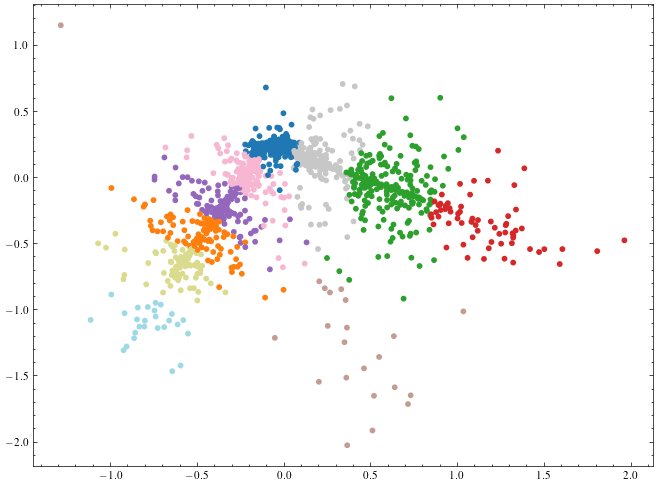


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.06261435054221866 (baseline: 0.0017740791383832719)
adjusted_rand_score: 0.030754632512532458 (baseline: 0.0002421637299593555)
completeness_score: 0.1674461144473921 (baseline: 0.12641404678871726)
entropy: 2.734855020734225 (baseline: 3.83785276088143)
fowlkes_mallows_score: 0.0955306451627305 (baseline: 0.029329443448879014)
homogeneity_completeness_v_measure: (np.float64(0.13331641146085227), np.float64(0.1674461144473921), np.float64(0.1484447906119781)) (baseline: (np.float64(0.14124005416751353), np.float64(0.12641404678871726), np.float64(0.13341642629187875)))
homogeneity_score: 0.13331641146085227 (baseline: 0.14124005416751353)
mutual_info_score: 0.45794084679888797 (baseline: 0.48515849848227277)
normalized_mutual_info_score: 0.1484447906119781 (baseline: 0.13341642629187872)
purity_score: 0.1545679012345679 (baseline: 0.12148148148148148)
rand_score: 0.8714214609866784 (baseline: 0.9407065827355683)
v_measure_score: 

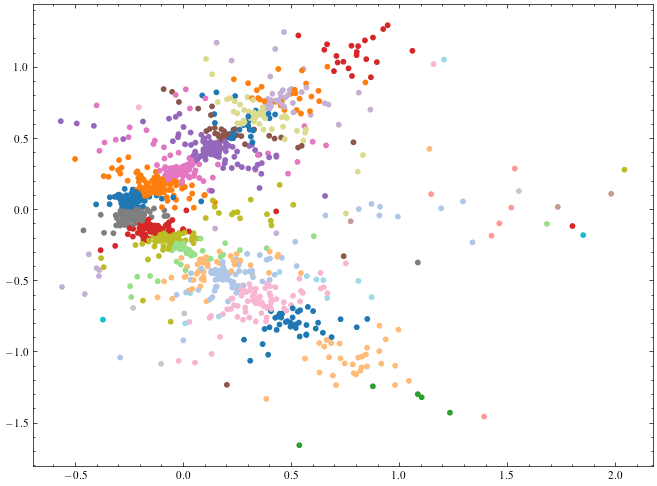


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.251050181701437 (baseline: -0.00032482775085141964)
adjusted_rand_score: -0.00940058041889397 (baseline: -0.0008312156968141323)
completeness_score: 0.26988391151291813 (baseline: 0.0005972947911834618)
entropy: 0.840019709815579 (baseline: 1.0976288518343595)
fowlkes_mallows_score: 0.4643143803951433 (baseline: 0.3755905917806007)
homogeneity_completeness_v_measure: (np.float64(0.23611834915901325), np.float64(0.26988391151291813), np.float64(0.2518745412970536)) (baseline: (np.float64(0.0006828220036527876), np.float64(0.0005972947911834618), np.float64(0.0006372012737157094)))
homogeneity_score: 0.23611834915901325 (baseline: 0.0006828220036527876)
mutual_info_score: 0.22670780503297489 (baseline: 0.0006556079958533467)
normalized_mutual_info_score: 0.2518745412970536 (baseline: 0.0006372012737157094)
purity_score: 0.6079012345679012 (baseline: 0.5624691358024692)
rand_score: 0.4922949299760894 (baseline: 0.52489679402722

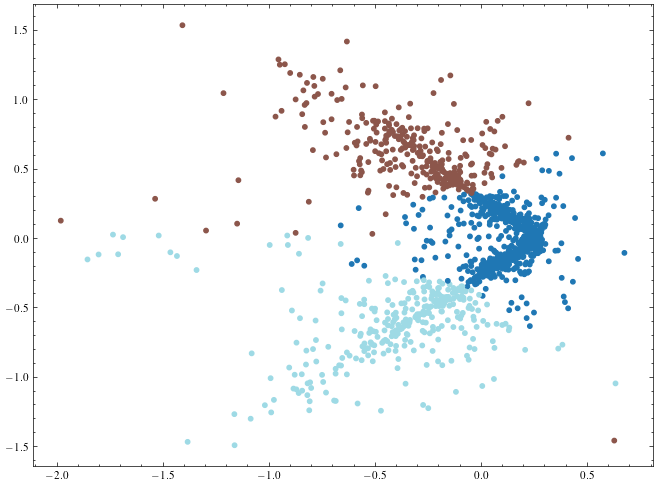


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.12036256168972438 (baseline: 0.008370347445676017)
adjusted_rand_score: 0.03064031045866487 (baseline: 0.001384290444490928)
completeness_score: 0.4085492127824985 (baseline: 0.4121252935186768)
entropy: 3.390733379131253 (baseline: 5.12282763424637)
fowlkes_mallows_score: 0.07049527591077148 (baseline: 0.012037801793370094)
homogeneity_completeness_v_measure: (np.float64(0.31207392833516984), np.float64(0.4085492127824985), np.float64(0.3538536316042529)) (baseline: (np.float64(0.47561821784624647), np.float64(0.4121252935186768), np.float64(0.44160119476703)))
homogeneity_score: 0.31207392833516984 (baseline: 0.47561821784624647)
mutual_info_score: 1.3852814527994144 (baseline: 2.111246842409374)
normalized_mutual_info_score: 0.3538536316042529 (baseline: 0.44160119476703)
purity_score: 0.2019753086419753 (baseline: 0.16197530864197532)
rand_score: 0.9213965744400527 (baseline: 0.9756516859415411)
v_measure_score: 0.35385

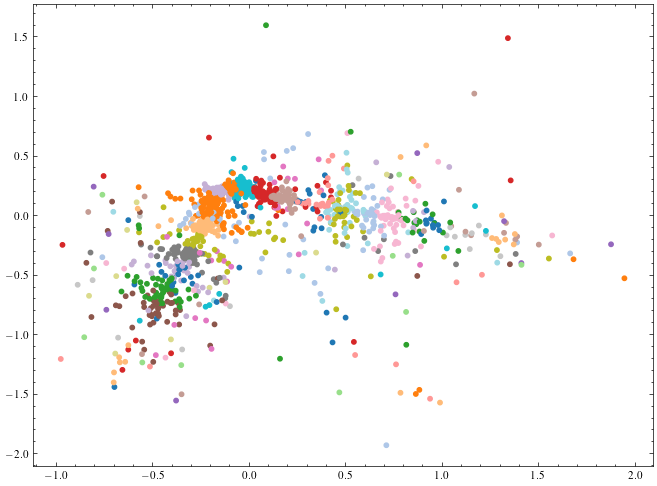


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.23635167974717095 (baseline: -0.0007148831903917278)
adjusted_rand_score: 0.013582168729152272 (baseline: -0.0001805157377731071)
completeness_score: 0.2673299014940545 (baseline: 0.011720496757668255)
entropy: 1.8691007207342047 (baseline: 2.4837263780735803)
fowlkes_mallows_score: 0.19597682006809214 (baseline: 0.11398458359645273)
homogeneity_completeness_v_measure: (np.float64(0.2315640993831428), np.float64(0.2673299014940545), np.float64(0.24816497199328993)) (baseline: (np.float64(0.013490894769089419), np.float64(0.011720496757668255), np.float64(0.012543535189744546)))
homogeneity_score: 0.2315640993831428 (baseline: 0.013490894769089419)
mutual_info_score: 0.49966651155634123 (baseline: 0.029110506961146514)
normalized_mutual_info_score: 0.2481649719932899 (baseline: 0.012543535189744544)
purity_score: 0.3506172839506173 (baseline: 0.31012345679012343)
rand_score: 0.6980081003269409 (baseline: 0.7860918362367

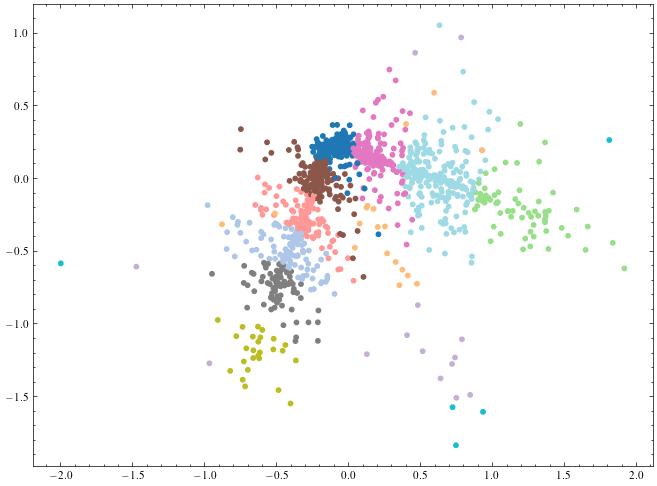


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.13620099959289514 (baseline: 0.0043125133864103165)
adjusted_rand_score: 0.03649385087448436 (baseline: 0.0007351610471705589)
completeness_score: 0.3405897439243144 (baseline: 0.29454715476075083)
entropy: 3.061071911126369 (baseline: 4.589955736136179)
fowlkes_mallows_score: 0.08477126185525254 (baseline: 0.015508751374815647)
homogeneity_completeness_v_measure: (np.float64(0.2548017939581572), np.float64(0.3405897439243144), np.float64(0.2915153213776288)) (baseline: (np.float64(0.3304157284402894), np.float64(0.29454715476075083), np.float64(0.3114521368110782)))
homogeneity_score: 0.2548017939581572 (baseline: 0.3304157284402894)
mutual_info_score: 1.0425696983444417 (baseline: 1.3519584025566993)
normalized_mutual_info_score: 0.2915153213776288 (baseline: 0.31145213681107825)
purity_score: 0.17530864197530865 (baseline: 0.12493827160493827)
rand_score: 0.9051485873225004 (baseline: 0.9686370955936173)
v_measure

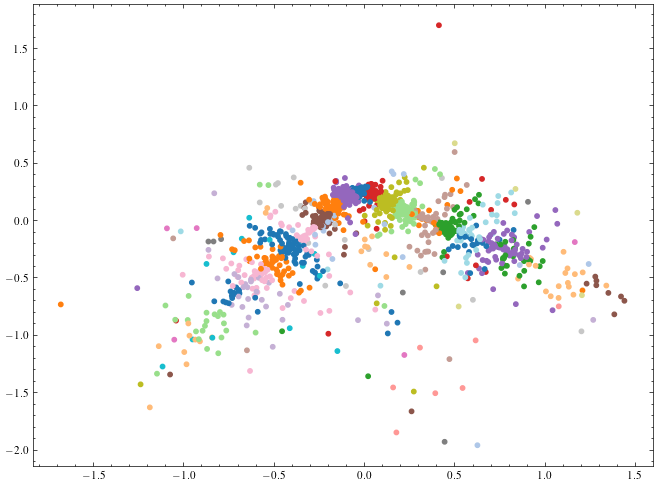


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.13106892090767805 (baseline: 0.0016095224620906626)
adjusted_rand_score: 0.03420864134571111 (baseline: 0.0003797139022904801)
completeness_score: 0.4272818462659048 (baseline: 0.42295353962618465)
entropy: 3.4010339160097125 (baseline: 5.172633384689242)
fowlkes_mallows_score: 0.07410370131477997 (baseline: 0.009951692005795452)
homogeneity_completeness_v_measure: (np.float64(0.3225960186717225), np.float64(0.4272818462659048), np.float64(0.36763166083732574)) (baseline: (np.float64(0.48566629103843745), np.float64(0.42295353962618465), np.float64(0.45214570481380506)))
homogeneity_score: 0.3225960186717225 (baseline: 0.48566629103843745)
mutual_info_score: 1.4532000508455902 (baseline: 2.187783599242887)
normalized_mutual_info_score: 0.36763166083732574 (baseline: 0.45214570481380506)
purity_score: 0.20444444444444446 (baseline: 0.15604938271604937)
rand_score: 0.9234323915483336 (baseline: 0.978008100326940

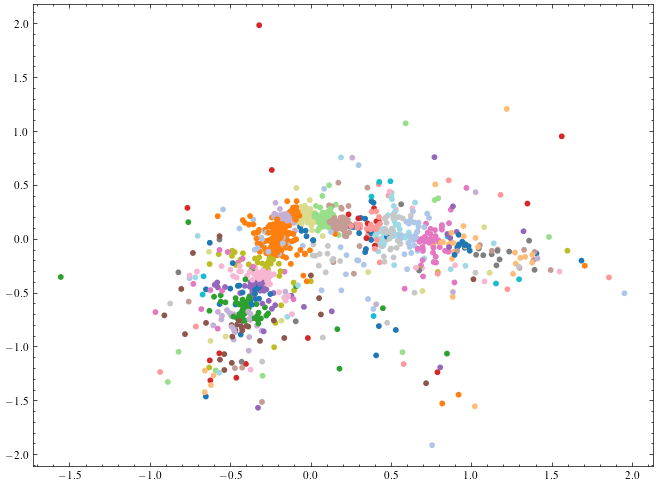

In [11]:
run_experiment(ts_1hour, subset_labels_1hour, label_maps, image_name="clusters_hour1")

In [12]:
ts_2hour, subset_labels_2hour = generate_timeseries_and_labels(unit_ids, 3600 * 2, 600, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.22957605081520693 (baseline: -0.0029699763503637003)
adjusted_rand_score: 0.039371557367469154 (baseline: -0.0012134314543791398)
completeness_score: 0.26930569904180535 (baseline: 0.0060441702800348674)
entropy: 1.6204061986284288 (baseline: 2.301436862240457)
fowlkes_mallows_score: 0.2320543179226589 (baseline: 0.126311008804309)
homogeneity_completeness_v_measure: (np.float64(0.21219774712283018), np.float64(0.26930569904180535), np.float64(0.23736512408873042)) (baseline: (np.float64(0.006764054292133061), np.float64(0.0060441702800348674), np.float64(0.0063838818088638545)))
homogeneity_score: 0.21219774712283018 (baseline: 0.006764054292133061)
mutual_info_score: 0.43638462405330347 (baseline: 0.01391027628413047)
normalized_mutual_info_score: 0.23736512408873042 (baseline: 0.0063838818088638545)
purity_score: 0.3545679012345679 (baseline: 0.31012345679012343)
rand_score: 0.6848260381593715 (baseline: 0.7697272239301225)
v_me

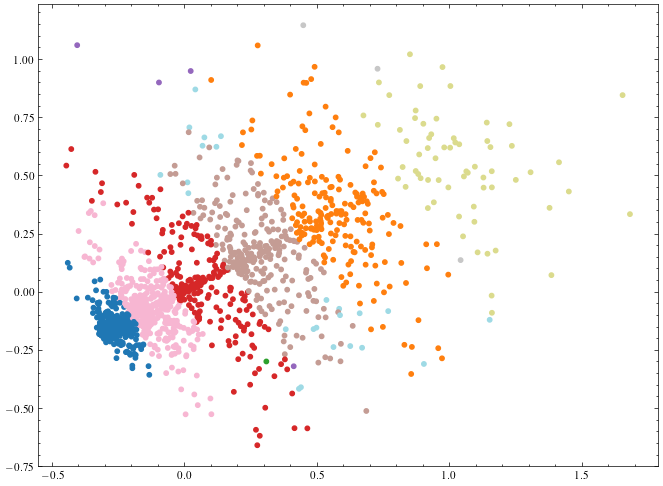


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.08123981626212269 (baseline: -0.0024912508954643376)
adjusted_rand_score: 0.03488744121296917 (baseline: -0.0002567582955300345)
completeness_score: 0.18927490989172122 (baseline: 0.12293324012435863)
entropy: 2.5043751556477445 (baseline: 3.8421267788495377)
fowlkes_mallows_score: 0.11075501952224434 (baseline: 0.028696545489207886)
homogeneity_completeness_v_measure: (np.float64(0.13799605371872706), np.float64(0.18927490989172122), np.float64(0.15961813626774995)) (baseline: (np.float64(0.13750397458717434), np.float64(0.12293324012435863), np.float64(0.1298110114155683)))
homogeneity_score: 0.13799605371872706 (baseline: 0.13750397458717434)
mutual_info_score: 0.47401538192029213 (baseline: 0.4723250938925388)
normalized_mutual_info_score: 0.15961813626774995 (baseline: 0.1298110114155683)
purity_score: 0.15901234567901235 (baseline: 0.1259259259259259)
rand_score: 0.8456263114234128 (baseline: 0.9408437027277607)
v_measure_s

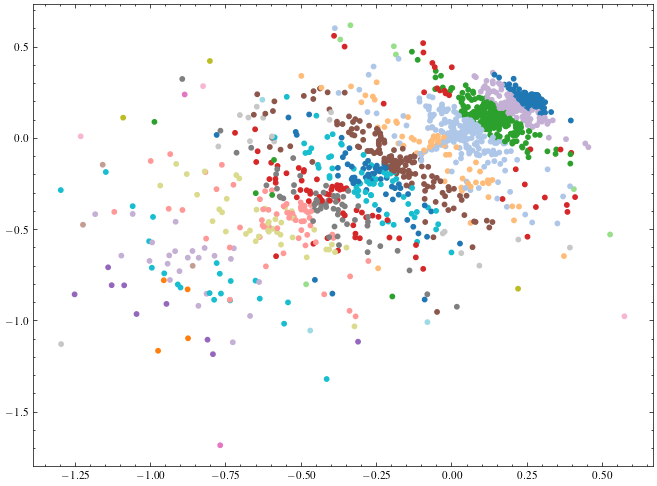


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.2723566601586535 (baseline: -0.00014704518950002887)
adjusted_rand_score: 0.03546124608595684 (baseline: 0.0002681030434972243)
completeness_score: 0.2875849822866395 (baseline: 0.0007633396341834723)
entropy: 0.8683358501990146 (baseline: 1.098207334992018)
fowlkes_mallows_score: 0.47635162284853333 (baseline: 0.37606982410090484)
homogeneity_completeness_v_measure: (np.float64(0.26008613513793233), np.float64(0.2875849822866395), np.float64(0.27314519311653934)) (baseline: (np.float64(0.0008731028754285266), np.float64(0.0007633396341834723), np.float64(0.0008145401083380198)))
homogeneity_score: 0.26008613513793233 (baseline: 0.0008731028754285266)
mutual_info_score: 0.24972035009833765 (baseline: 0.0008383051853504131)
normalized_mutual_info_score: 0.2731451931165394 (baseline: 0.0008145401083380196)
purity_score: 0.6355555555555555 (baseline: 0.5624691358024692)
rand_score: 0.5188181330210315 (baseline: 0.52547650417215

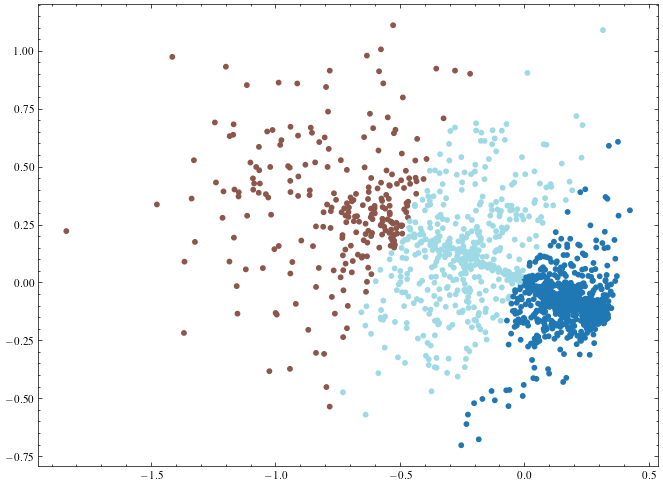


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.1436029838161597 (baseline: 0.006362677407364047)
adjusted_rand_score: 0.03613212895055877 (baseline: 0.0010697184257540677)
completeness_score: 0.43823513137821085 (baseline: 0.41205593728607415)
entropy: 2.9653193655296004 (baseline: 5.13777697797531)
fowlkes_mallows_score: 0.09805004173132569 (baseline: 0.01151659690860957)
homogeneity_completeness_v_measure: (np.float64(0.29275082804195485), np.float64(0.43823513137821085), np.float64(0.3510154906116432)) (baseline: (np.float64(0.47692588341885683), np.float64(0.41205593728607415), np.float64(0.44212409597377933)))
homogeneity_score: 0.29275082804195485 (baseline: 0.47692588341885683)
mutual_info_score: 1.2995071217312173 (baseline: 2.11705150822643)
normalized_mutual_info_score: 0.3510154906116432 (baseline: 0.4421240959737793)
purity_score: 0.2074074074074074 (baseline: 0.15851851851851853)
rand_score: 0.871939198750793 (baseline: 0.9758171082808764)
v_measure_score: 

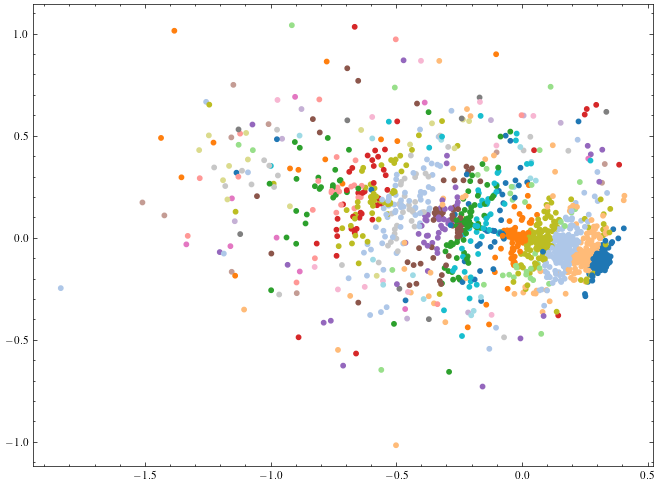


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.26002867353351505 (baseline: 0.0011211760739879204)
adjusted_rand_score: 0.03570777473184659 (baseline: 0.00037800180262793687)
completeness_score: 0.3021858078864471 (baseline: 0.013416086313550056)
entropy: 1.752143329235487 (baseline: 2.483293279004494)
fowlkes_mallows_score: 0.21941960372282915 (baseline: 0.11455597745267536)
homogeneity_completeness_v_measure: (np.float64(0.2453774672474069), np.float64(0.3021858078864471), np.float64(0.27083477488208724)) (baseline: (np.float64(0.015439912783425299), np.float64(0.013416086313550056), np.float64(0.01435702862895024)))
homogeneity_score: 0.2453774672474069 (baseline: 0.015439912783425299)
mutual_info_score: 0.5294728474778747 (baseline: 0.033316076972983034)
normalized_mutual_info_score: 0.2708347748820872 (baseline: 0.014357028628950242)
purity_score: 0.3540740740740741 (baseline: 0.31012345679012343)
rand_score: 0.6966959449568145 (baseline: 0.7861630800761236)
v

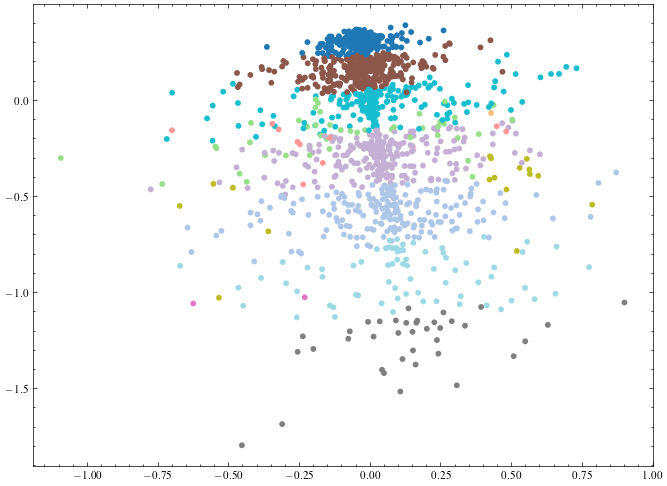


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.15475894457131134 (baseline: 0.0027328231560796593)
adjusted_rand_score: 0.04136106635100015 (baseline: 0.00021170693466923666)
completeness_score: 0.3698294358900315 (baseline: 0.29344102770380964)
entropy: 2.748378398296656 (baseline: 4.5870493214416195)
fowlkes_mallows_score: 0.10756959988851138 (baseline: 0.01501361628417708)
homogeneity_completeness_v_measure: (np.float64(0.2484136091109357), np.float64(0.3698294358900315), np.float64(0.2971991862027673)) (baseline: (np.float64(0.328966464935631), np.float64(0.29344102770380964), np.float64(0.3101898955021795)))
homogeneity_score: 0.2484136091109357 (baseline: 0.328966464935631)
mutual_info_score: 1.0164312326544005 (baseline: 1.3460284670118914)
normalized_mutual_info_score: 0.2971991862027673 (baseline: 0.31018989550217946)
purity_score: 0.1728395061728395 (baseline: 0.12197530864197531)
rand_score: 0.8660557263455814 (baseline: 0.9685395012931245)
v_measure_s

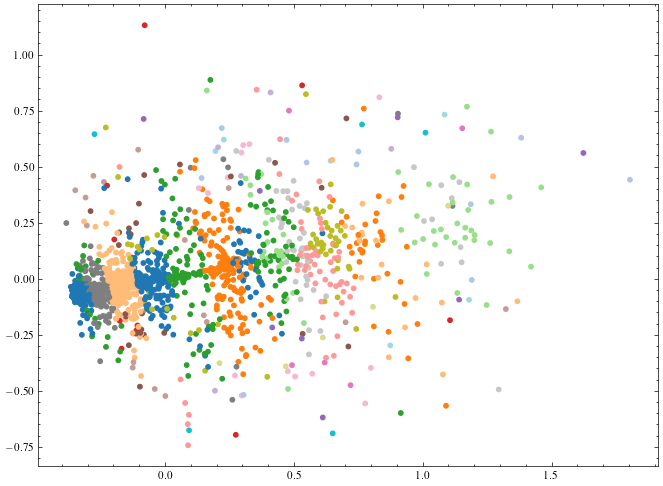


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.15084031228320677 (baseline: 0.0012964850948461763)
adjusted_rand_score: 0.04083610686412816 (baseline: 0.00029403572644337854)
completeness_score: 0.45062766485460465 (baseline: 0.4227647813628205)
entropy: 3.0993755498245625 (baseline: 5.171546495840223)
fowlkes_mallows_score: 0.09803274188422476 (baseline: 0.009875831729074)
homogeneity_completeness_v_measure: (np.float64(0.3100456566867199), np.float64(0.45062766485460465), np.float64(0.3673459981163775)) (baseline: (np.float64(0.4853475408715346), np.float64(0.4227647813628205), np.float64(0.4518997088304775)))
homogeneity_score: 0.3100456566867199 (baseline: 0.4853475408715346)
mutual_info_score: 1.396664366524899 (baseline: 2.1863477236215525)
normalized_mutual_info_score: 0.3673459981163776 (baseline: 0.45189970883047753)
purity_score: 0.20938271604938272 (baseline: 0.15259259259259259)
rand_score: 0.8899682818523398 (baseline: 0.9779802859513005)
v_me

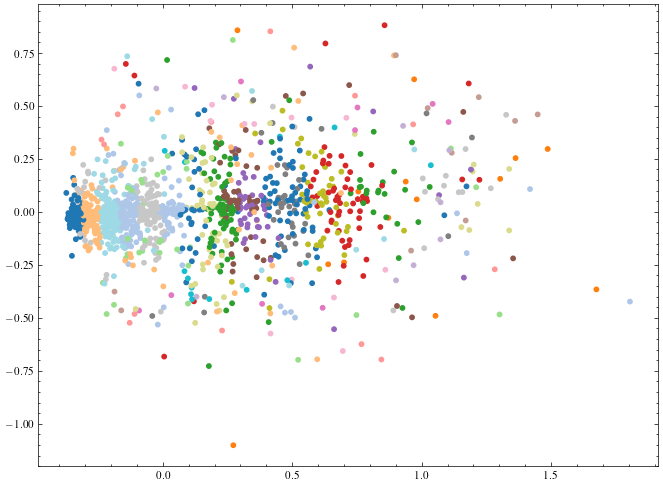

In [13]:
run_experiment(ts_2hour, subset_labels_2hour, label_maps, image_name="clusters_hour2")

In [14]:
ts_3hour, subset_labels_3hour = generate_timeseries_and_labels(unit_ids, 3600 * 3, 400, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.2286828220783558 (baseline: -0.0005187734289158872)
adjusted_rand_score: 0.02945216363034428 (baseline: -0.0004777628369356079)
completeness_score: 0.25824943088530306 (baseline: 0.008347460949325265)
entropy: 1.738703198552348 (baseline: 2.30042731184858)
fowlkes_mallows_score: 0.21595053492207963 (baseline: 0.1271028625990439)
homogeneity_completeness_v_measure: (np.float64(0.21834143236158718), np.float64(0.25824943088530306), np.float64(0.236624555753817)) (baseline: (np.float64(0.009337577943304504), np.float64(0.008347460949325265), np.float64(0.008814803033936084)))
homogeneity_score: 0.21834143236158718 (baseline: 0.009337577943304504)
mutual_info_score: 0.4490191115046 (baseline: 0.019202727152417314)
normalized_mutual_info_score: 0.23662455575381702 (baseline: 0.008814803033936084)
purity_score: 0.3550617283950617 (baseline: 0.31012345679012343)
rand_score: 0.6941262870248377 (baseline: 0.769761381935295)
v_measure_score:

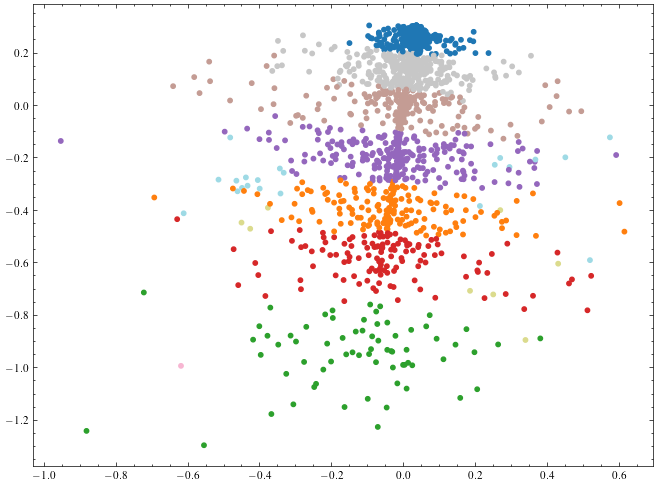


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.0753752524272041 (baseline: -0.002528469627455926)
adjusted_rand_score: 0.03558433048713086 (baseline: -0.0006998242528552701)
completeness_score: 0.18362074263581937 (baseline: 0.12288049286751827)
entropy: 2.553779838115683 (baseline: 3.8386587014090257)
fowlkes_mallows_score: 0.1105784434359072 (baseline: 0.028345437941908566)
homogeneity_completeness_v_measure: (np.float64(0.13651470206694258), np.float64(0.18362074263581937), np.float64(0.15660203447646143)) (baseline: (np.float64(0.13732091137819566), np.float64(0.12288049286751827), np.float64(0.12970000158212008)))
homogeneity_score: 0.13651470206694258 (baseline: 0.13732091137819566)
mutual_info_score: 0.4689269504031843 (baseline: 0.4716962731793287)
normalized_mutual_info_score: 0.15660203447646145 (baseline: 0.12970000158212006)
purity_score: 0.16049382716049382 (baseline: 0.12197530864197531)
rand_score: 0.8481271653735422 (baseline: 0.940682184160445)
v_measure_scor

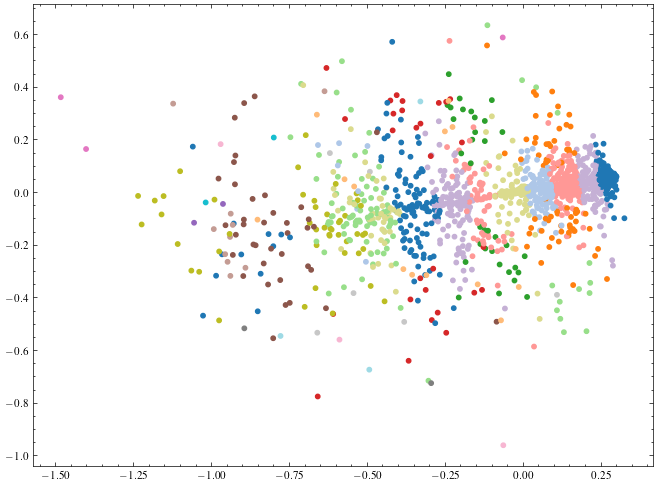


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.27278058448665493 (baseline: 0.00042170044671835085)
adjusted_rand_score: 0.03786539179017675 (baseline: 0.0007399071201941649)
completeness_score: 0.2913620118961972 (baseline: 0.0012955308974762552)
entropy: 0.8496719395485497 (baseline: 1.098501470132495)
fowlkes_mallows_score: 0.4817489406051498 (baseline: 0.3762571629013214)
homogeneity_completeness_v_measure: (np.float64(0.2578383238279631), np.float64(0.2913620118961972), np.float64(0.2735770096549621)) (baseline: (np.float64(0.0014822166365806109), np.float64(0.0012955308974762552), np.float64(0.0013826004169925426)))
homogeneity_score: 0.2578383238279631 (baseline: 0.0014822166365806109)
mutual_info_score: 0.2475621257586095 (baseline: 0.0014231425954797372)
normalized_mutual_info_score: 0.2735770096549622 (baseline: 0.0013826004169925428)
purity_score: 0.6316049382716049 (baseline: 0.5624691358024692)
rand_score: 0.5186815010003416 (baseline: 0.5257302493534377)
v_

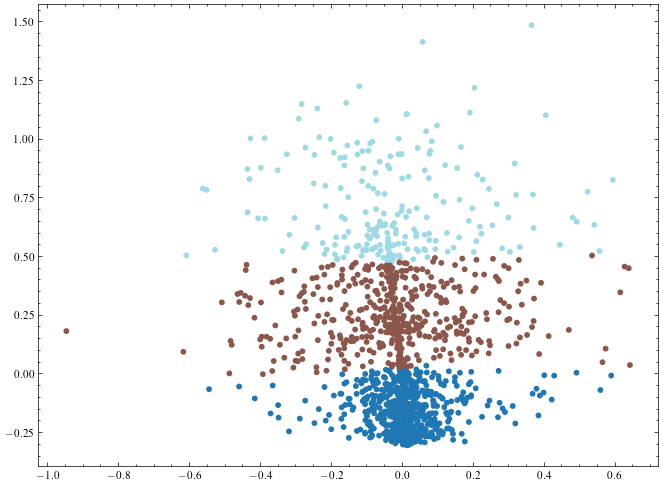


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.14644701127657353 (baseline: -0.0001800087771499446)
adjusted_rand_score: 0.041866004047500724 (baseline: -8.210706929483573e-05)
completeness_score: 0.4403721506006479 (baseline: 0.40796239288708874)
entropy: 3.2040508823387874 (baseline: 5.128587409096367)
fowlkes_mallows_score: 0.09702613705457515 (baseline: 0.01024214851140143)
homogeneity_completeness_v_measure: (np.float64(0.3178620783275177), np.float64(0.4403721506006479), np.float64(0.36921996313817673)) (baseline: (np.float64(0.4713433243035698), np.float64(0.40796239288708874), np.float64(0.4373685890923086)))
homogeneity_score: 0.3178620783275177 (baseline: 0.4713433243035698)
mutual_info_score: 1.4109747776894352 (baseline: 2.0922707915455487)
normalized_mutual_info_score: 0.36921996313817673 (baseline: 0.43736858909230864)
purity_score: 0.21925925925925926 (baseline: 0.15160493827160493)
rand_score: 0.8939911189186551 (baseline: 0.9756999951202849)
v_measure_s

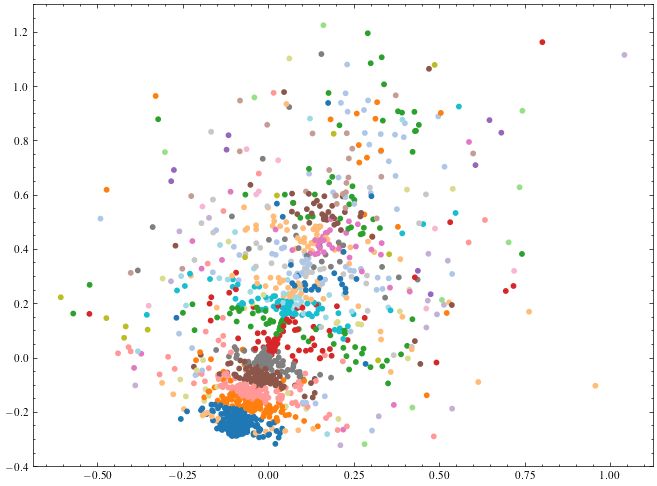


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.2639336693581334 (baseline: -0.00249148035883681)
adjusted_rand_score: 0.035223829976070486 (baseline: -0.0004706883578712674)
completeness_score: 0.30546995853588443 (baseline: 0.010088375701352223)
entropy: 1.755306846020554 (baseline: 2.4826917838539613)
fowlkes_mallows_score: 0.21719072164557585 (baseline: 0.11382756572676783)
homogeneity_completeness_v_measure: (np.float64(0.248492072700953), np.float64(0.30546995853588443), np.float64(0.27405077916613874)) (baseline: (np.float64(0.011607402394240829), np.float64(0.010088375701352223), np.float64(0.01079471183323567)))
homogeneity_score: 0.248492072700953 (baseline: 0.011607402394240829)
mutual_info_score: 0.5361935094716528 (baseline: 0.02504632746617911)
normalized_mutual_info_score: 0.27405077916613874 (baseline: 0.01079471183323567)
purity_score: 0.3540740740740741 (baseline: 0.31012345679012343)
rand_score: 0.6994603035182745 (baseline: 0.7859151905528717)
v_

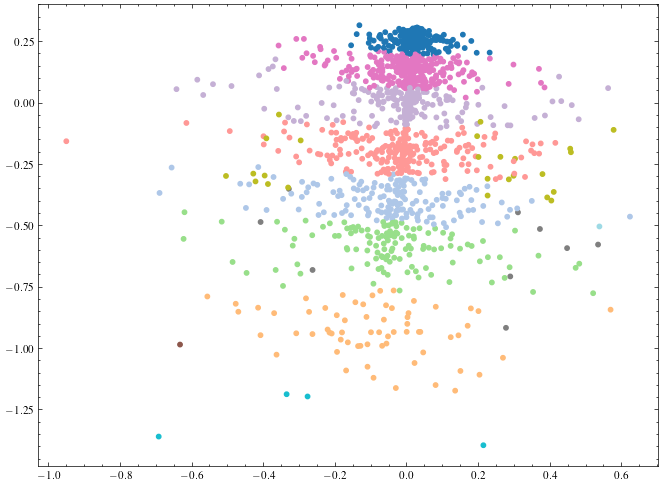


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.16032033080554176 (baseline: 4.010749801009016e-05)
adjusted_rand_score: 0.045193423639610604 (baseline: -2.784266984748967e-06)
completeness_score: 0.36937386328475 (baseline: 0.29212706012511097)
entropy: 2.9037811665600017 (baseline: 4.594767925338299)
fowlkes_mallows_score: 0.10430701201752625 (baseline: 0.01466805524684629)
homogeneity_completeness_v_measure: (np.float64(0.2621364592412614), np.float64(0.36937386328475), np.float64(0.30665011545790505)) (baseline: (np.float64(0.32804449334329555), np.float64(0.29212706012511097), np.float64(0.30904569193688564)))
homogeneity_score: 0.2621364592412614 (baseline: 0.32804449334329555)
mutual_info_score: 1.072580867625766 (baseline: 1.3422560459862327)
normalized_mutual_info_score: 0.30665011545790505 (baseline: 0.3090456919368856)
purity_score: 0.18814814814814815 (baseline: 0.12197530864197531)
rand_score: 0.8860791489776997 (baseline: 0.9686834528863514)
v_measur

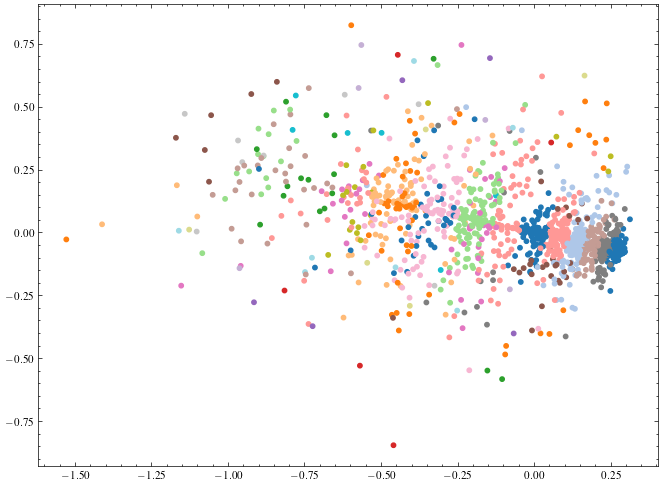


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.1577472047012947 (baseline: 0.0015260405157353522)
adjusted_rand_score: 0.04558380475588474 (baseline: 0.00041566637893742525)
completeness_score: 0.4605280085121479 (baseline: 0.42276691233176145)
entropy: 3.2211087114062833 (baseline: 5.170222659687075)
fowlkes_mallows_score: 0.10202425383661667 (baseline: 0.01002257112603229)
homogeneity_completeness_v_measure: (np.float64(0.3293025013488333), np.float64(0.4605280085121479), np.float64(0.38401409733067843)) (baseline: (np.float64(0.48522574518006456), np.float64(0.42276691233176145), np.float64(0.45184812537095254)))
homogeneity_score: 0.3293025013488333 (baseline: 0.48522574518006456)
mutual_info_score: 1.4834107800650667 (baseline: 2.185799069903612)
normalized_mutual_info_score: 0.38401409733067843 (baseline: 0.4518481253709526)
purity_score: 0.22271604938271605 (baseline: 0.15308641975308643)
rand_score: 0.8961137949543747 (baseline: 0.9779758942077783)

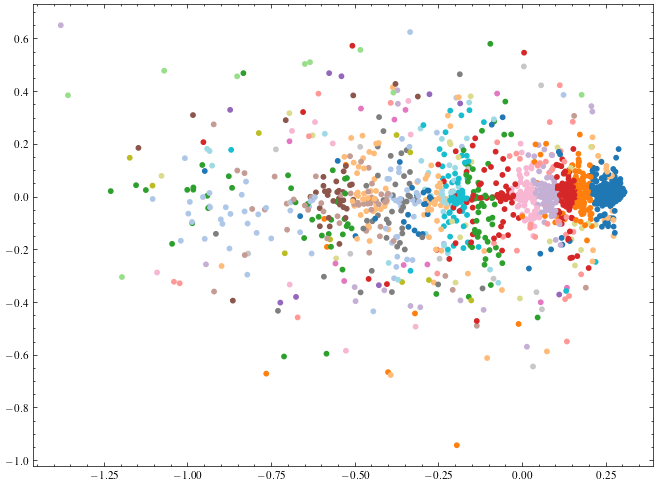

In [15]:
run_experiment(ts_3hour, subset_labels_3hour, label_maps, image_name="clusters_hour3")

In [16]:
ts_6hour, subset_labels_6hour = generate_timeseries_and_labels(unit_ids, 3600 * 6, 200, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.2358731994760246 (baseline: 0.0009290544559185059)
adjusted_rand_score: 0.027765458990577016 (baseline: 0.00047829005596953806)
completeness_score: 0.2610014774769098 (baseline: 0.009700817109191236)
entropy: 1.808739872335566 (baseline: 2.3015431922590337)
fowlkes_mallows_score: 0.21123907593250943 (baseline: 0.12782520101132502)
homogeneity_completeness_v_measure: (np.float64(0.22955692947516346), np.float64(0.2610014774769098), np.float64(0.24427141359309745)) (baseline: (np.float64(0.010856723448654172), np.float64(0.009700817109191236), np.float64(0.010246273213871294)))
homogeneity_score: 0.22955692947516346 (baseline: 0.010856723448654172)
mutual_info_score: 0.47208377905098003 (baseline: 0.02232684957700905)
normalized_mutual_info_score: 0.24427141359309745 (baseline: 0.010246273213871296)
purity_score: 0.3575308641975309 (baseline: 0.31012345679012343)
rand_score: 0.6987171229200214 (baseline: 0.7701298004196555)
v_measure

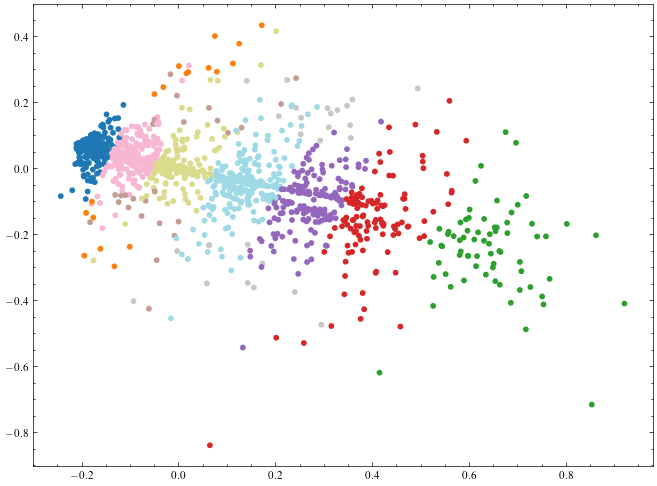


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.08815429715742874 (baseline: 0.00530697554516188)
adjusted_rand_score: 0.04006280264536497 (baseline: 0.0014326667873907396)
completeness_score: 0.19622148121471195 (baseline: 0.1293406839268847)
entropy: 2.6606171108845955 (baseline: 3.84138923051091)
fowlkes_mallows_score: 0.11130604073339596 (baseline: 0.030443016124257608)
homogeneity_completeness_v_measure: (np.float64(0.15198585175295545), np.float64(0.19622148121471195), np.float64(0.17129385932497712)) (baseline: (np.float64(0.14464309289403826), np.float64(0.1293406839268847), np.float64(0.13656455704997902)))
homogeneity_score: 0.15198585175295545 (baseline: 0.14464309289403826)
mutual_info_score: 0.5220702304429828 (baseline: 0.49684791030365044)
normalized_mutual_info_score: 0.1712938593249771 (baseline: 0.13656455704997902)
purity_score: 0.16691358024691358 (baseline: 0.12691358024691357)
rand_score: 0.8588966964329283 (baseline: 0.9409144585956181)
v_measure_score: 

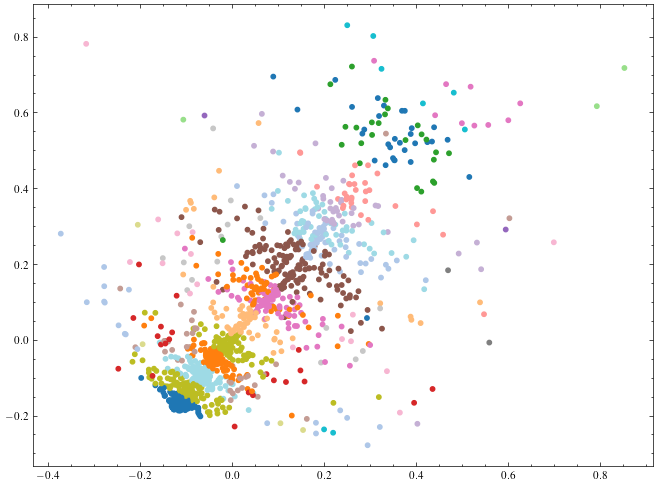


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.27412792014562254 (baseline: -0.0006218706921374365)
adjusted_rand_score: 0.0331540544457301 (baseline: -0.0005878720720968163)
completeness_score: 0.28994745575700864 (baseline: 0.00031878827711734933)
entropy: 0.865498306123062 (baseline: 1.0982079265376625)
fowlkes_mallows_score: 0.47619038704916805 (baseline: 0.3755283013131674)
homogeneity_completeness_v_measure: (np.float64(0.26136581891538807), np.float64(0.28994745575700864), np.float64(0.2749157609578527)) (baseline: (np.float64(0.000364628140429224), np.float64(0.00031878827711734933), np.float64(0.00034017086418037005)))
homogeneity_score: 0.26136581891538807 (baseline: 0.000364628140429224)
mutual_info_score: 0.25094903182238243 (baseline: 0.00035009581281755797)
normalized_mutual_info_score: 0.27491576095785275 (baseline: 0.00034017086418037)
purity_score: 0.6345679012345679 (baseline: 0.5624691358024692)
rand_score: 0.5173088371639096 (baseline: 0.5250705118821

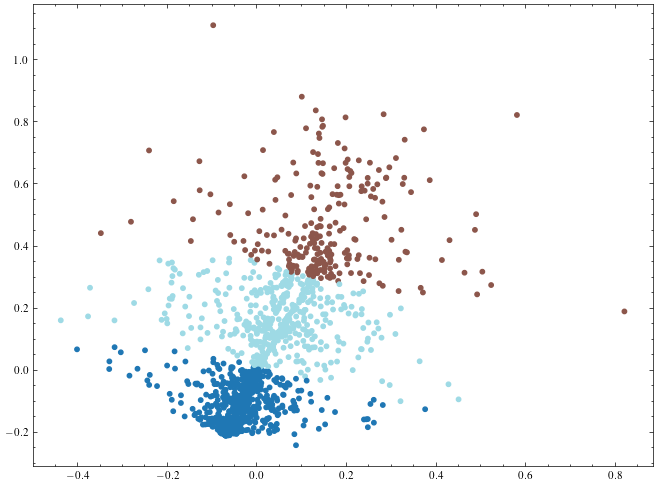


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.1573194233099983 (baseline: 0.0015527931673860232)
adjusted_rand_score: 0.04767136685481127 (baseline: 0.00026858767759055537)
completeness_score: 0.44961137457818423 (baseline: 0.40933678148656094)
entropy: 3.4193556124366205 (baseline: 5.135163266623945)
fowlkes_mallows_score: 0.0968535209516671 (baseline: 0.010591125582962895)
homogeneity_completeness_v_measure: (np.float64(0.3463387041746107), np.float64(0.44961137457818423), np.float64(0.3912753450507201)) (baseline: (np.float64(0.47353762840119024), np.float64(0.40933678148656094), np.float64(0.4391029268753337)))
homogeneity_score: 0.3463387041746107 (baseline: 0.47353762840119024)
mutual_info_score: 1.5373811770792578 (baseline: 2.10201120396786)
normalized_mutual_info_score: 0.3912753450507201 (baseline: 0.4391029268753337)
purity_score: 0.22271604938271605 (baseline: 0.15654320987654322)
rand_score: 0.9103176694481042 (baseline: 0.9757761186746694)
v_measure_score

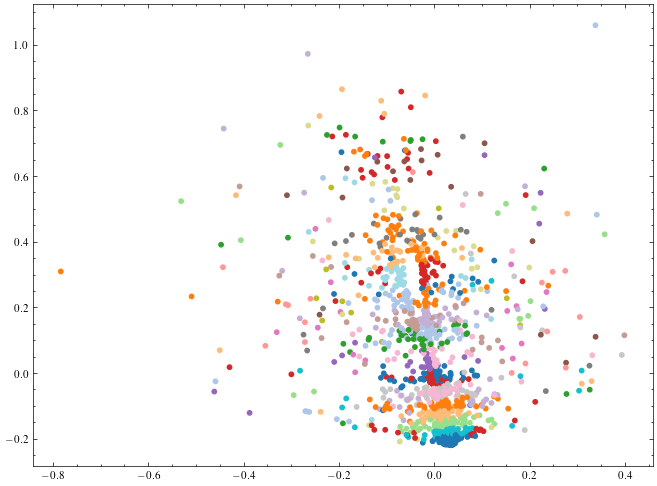


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.2693755468490669 (baseline: 0.003529421007705698)
adjusted_rand_score: 0.028142157383852666 (baseline: 4.057083490278652e-05)
completeness_score: 0.2952560786394448 (baseline: 0.015640328993216025)
entropy: 1.9533530899808376 (baseline: 2.482741865530615)
fowlkes_mallows_score: 0.19912974015979923 (baseline: 0.1143039255102893)
homogeneity_completeness_v_measure: (np.float64(0.26728253850351325), np.float64(0.2952560786394448), np.float64(0.280573783923135)) (baseline: (np.float64(0.017995687287438365), np.float64(0.015640328993216025), np.float64(0.016735541289201416)))
homogeneity_score: 0.26728253850351325 (baseline: 0.017995687287438365)
mutual_info_score: 0.5767393735459847 (baseline: 0.03883089958212972)
normalized_mutual_info_score: 0.28057378392313503 (baseline: 0.01673554128920142)
purity_score: 0.35555555555555557 (baseline: 0.31012345679012343)
rand_score: 0.7162152930268872 (baseline: 0.7860269360269361)
v_

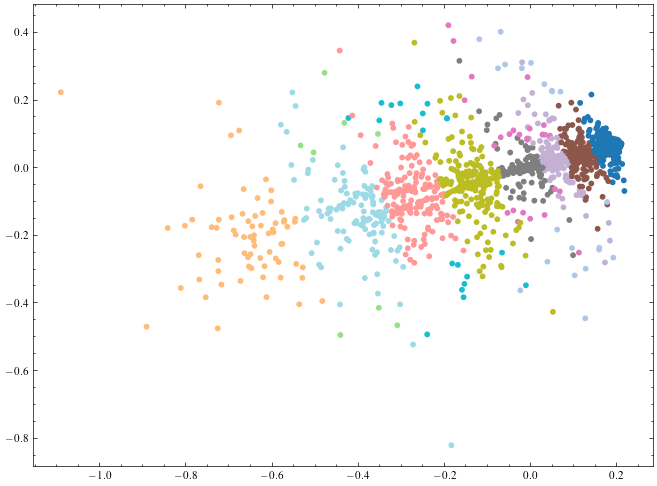


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.1784821750157534 (baseline: 0.0015015977274193961)
adjusted_rand_score: 0.04778770590027798 (baseline: -0.00014924211187144777)
completeness_score: 0.3925591137494012 (baseline: 0.2929667529755412)
entropy: 3.026400867253829 (baseline: 4.593465934029354)
fowlkes_mallows_score: 0.10863141407134656 (baseline: 0.014523461039842272)
homogeneity_completeness_v_measure: (np.float64(0.29035472670547635), np.float64(0.3925591137494012), np.float64(0.3338090032339373)) (baseline: (np.float64(0.3288942044546131), np.float64(0.2929667529755412), np.float64(0.30989264079137535)))
homogeneity_score: 0.29035472670547635 (baseline: 0.3288942044546131)
mutual_info_score: 1.1880412422995823 (baseline: 1.3457327995963415)
normalized_mutual_info_score: 0.33380900323393736 (baseline: 0.3098926407913753)
purity_score: 0.19407407407407407 (baseline: 0.11851851851851852)
rand_score: 0.8840984726491973 (baseline: 0.9686639340262528)
v_measu

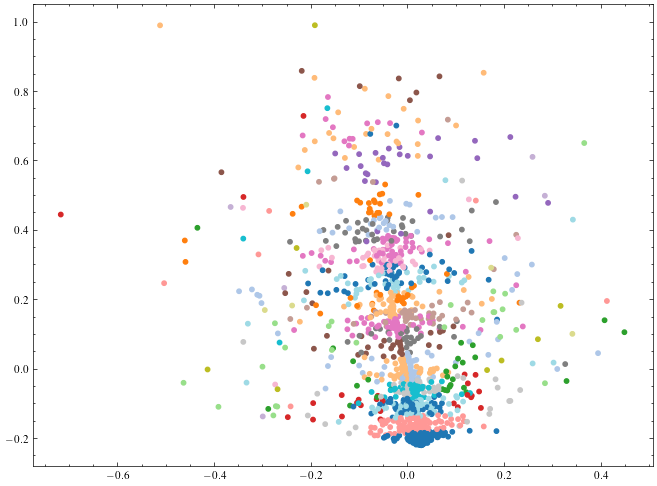


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.16918852192224934 (baseline: 0.005261860264284074)
adjusted_rand_score: 0.051821454761636854 (baseline: 0.0011772768680240466)
completeness_score: 0.46888877622112796 (baseline: 0.4241670580599234)
entropy: 3.425268114884707 (baseline: 5.163712863311701)
fowlkes_mallows_score: 0.10234190028063489 (baseline: 0.010943061317917478)
homogeneity_completeness_v_measure: (np.float64(0.35653158331444423), np.float64(0.46888877622112796), np.float64(0.40506308295703336)) (baseline: (np.float64(0.4862197777578736), np.float64(0.4241670580599234), np.float64(0.45307863556011074)))
homogeneity_score: 0.35653158331444423 (baseline: 0.4862197777578736)
mutual_info_score: 1.6060697746175403 (baseline: 2.1902768938971073)
normalized_mutual_info_score: 0.40506308295703336 (baseline: 0.4530786355601108)
purity_score: 0.22469135802469137 (baseline: 0.16)
rand_score: 0.9123095691211633 (baseline: 0.9779436880886156)
v_measure_sco

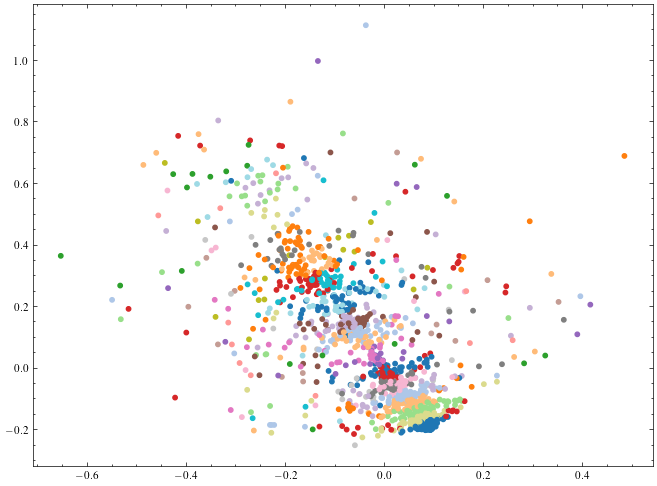

In [17]:
run_experiment(ts_6hour, subset_labels_6hour, label_maps, image_name="clusters_hour6")

In [18]:
ts_12hour, subset_labels_12hour = generate_timeseries_and_labels(unit_ids, 3600 * 12, 100, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.24015015791180083 (baseline: -0.002935189443697019)
adjusted_rand_score: 0.024485042360101954 (baseline: -0.000733077486164384)
completeness_score: 0.26075742105881217 (baseline: 0.0060801142979459545)
entropy: 1.8681268218273281 (baseline: 2.3005358176550157)
fowlkes_mallows_score: 0.20622594715287562 (baseline: 0.12685754013969444)
homogeneity_completeness_v_measure: (np.float64(0.23687234629920026), np.float64(0.26075742105881217), np.float64(0.24824166958120303)) (baseline: (np.float64(0.006801615411182492), np.float64(0.0060801142979459545), np.float64(0.006420659343807672)))
homogeneity_score: 0.23687234629920026 (baseline: 0.006801615411182492)
mutual_info_score: 0.4871279322704892 (baseline: 0.013987520717861048)
normalized_mutual_info_score: 0.24824166958120303 (baseline: 0.006420659343807672)
purity_score: 0.3585185185185185 (baseline: 0.31012345679012343)
rand_score: 0.7012296881862099 (baseline: 0.7697184404430781)
v_me

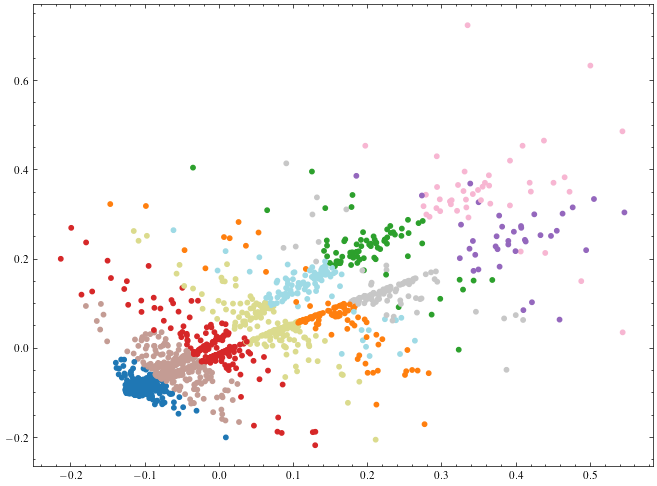


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.12259371883591123 (baseline: -0.003602538944501006)
adjusted_rand_score: 0.04890894633097132 (baseline: -0.0006986613525479069)
completeness_score: 0.23338490181040006 (baseline: 0.12201528832539976)
entropy: 2.791663933850646 (baseline: 3.839744003018488)
fowlkes_mallows_score: 0.11757693660022808 (baseline: 0.02832040362688388)
homogeneity_completeness_v_measure: (np.float64(0.18967501415825397), np.float64(0.23338490181040006), np.float64(0.20927193943134173)) (baseline: (np.float64(0.13639258278906566), np.float64(0.12201528832539976), np.float64(0.12880397367680804)))
homogeneity_score: 0.18967501415825397 (baseline: 0.13639258278906566)
mutual_info_score: 0.6515322130893682 (baseline: 0.4685074716240255)
normalized_mutual_info_score: 0.20927193943134173 (baseline: 0.12880397367680804)
purity_score: 0.18567901234567902 (baseline: 0.12049382716049382)
rand_score: 0.8673776411457571 (baseline: 0.9407173181086225)
v_measure_sco

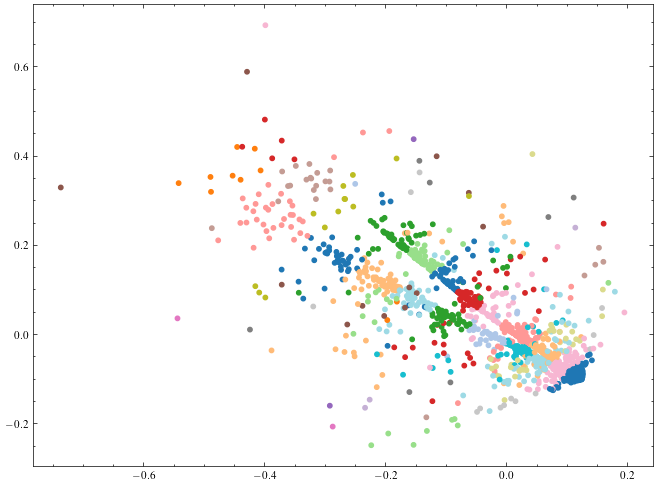


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.28247306889574075 (baseline: -0.00012510994244004293)
adjusted_rand_score: 0.04216815923455263 (baseline: -3.168851454036142e-05)
completeness_score: 0.3006844457372325 (baseline: 0.0007835831454545699)
entropy: 0.8549409862116666 (baseline: 1.098585950872708)
fowlkes_mallows_score: 0.48287517235229954 (baseline: 0.3757382429479612)
homogeneity_completeness_v_measure: (np.float64(0.2677382168675756), np.float64(0.3006844457372325), np.float64(0.28325653650960175)) (baseline: (np.float64(0.0008965662630302986), np.float64(0.0007835831454545699), np.float64(0.0008362758799257794)))
homogeneity_score: 0.2677382168675756 (baseline: 0.0008965662630302986)
mutual_info_score: 0.2570674565770979 (baseline: 0.0008608334349370361)
normalized_mutual_info_score: 0.2832565365096017 (baseline: 0.0008362758799257793)
purity_score: 0.6365432098765432 (baseline: 0.5624691358024692)
rand_score: 0.52122968818621 (baseline: 0.5253725662421315)


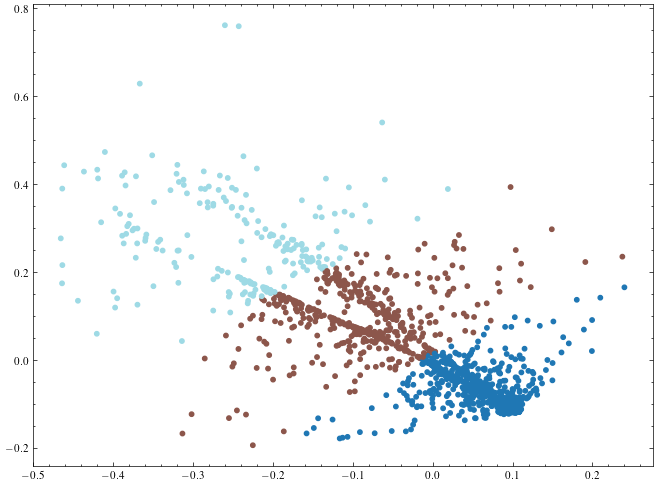


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.17719155225087244 (baseline: 0.0024186529480448894)
adjusted_rand_score: 0.05935621165256837 (baseline: 0.0009167115601543546)
completeness_score: 0.4627319136659032 (baseline: 0.4096929853472238)
entropy: 3.617598281096281 (baseline: 5.132739910243513)
fowlkes_mallows_score: 0.1000150224352781 (baseline: 0.011396995083557588)
homogeneity_completeness_v_measure: (np.float64(0.37711105141530443), np.float64(0.4627319136659032), np.float64(0.41555701658843197)) (baseline: (np.float64(0.4737260360953892), np.float64(0.4096929853472238), np.float64(0.4393888500333458)))
homogeneity_score: 0.37711105141530443 (baseline: 0.4737260360953892)
mutual_info_score: 1.6739781754861642 (baseline: 2.1028475368385067)
normalized_mutual_info_score: 0.4155570165884319 (baseline: 0.4393888500333458)
purity_score: 0.2345679012345679 (baseline: 0.16)
rand_score: 0.929884350753916 (baseline: 0.9757453764700141)
v_measure_score: 0.415557016588431

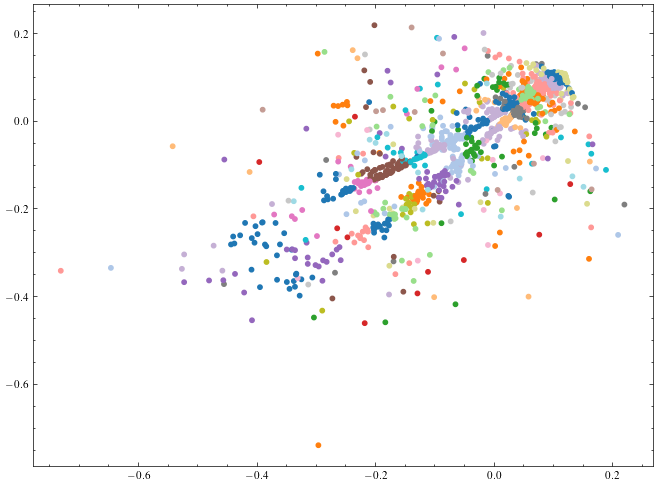


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.2783143704978925 (baseline: -0.0020534417583288364)
adjusted_rand_score: 0.027813353944432476 (baseline: -0.0002606520585485874)
completeness_score: 0.30638423034208784 (baseline: 0.010484262604131602)
entropy: 1.9338797297544204 (baseline: 2.484090005313057)
fowlkes_mallows_score: 0.20397454807405851 (baseline: 0.11386789472085083)
homogeneity_completeness_v_measure: (np.float64(0.2745913521109194), np.float64(0.30638423034208784), np.float64(0.2896178862453389)) (baseline: (np.float64(0.01206969244751293), np.float64(0.010484262604131602), np.float64(0.011221253645409086)))
homogeneity_score: 0.2745913521109194 (baseline: 0.01206969244751293)
mutual_info_score: 0.5925102525749729 (baseline: 0.026043851948000754)
normalized_mutual_info_score: 0.2896178862453389 (baseline: 0.011221253645409086)
purity_score: 0.36987654320987656 (baseline: 0.31012345679012343)
rand_score: 0.708294051627385 (baseline: 0.786116234811887)


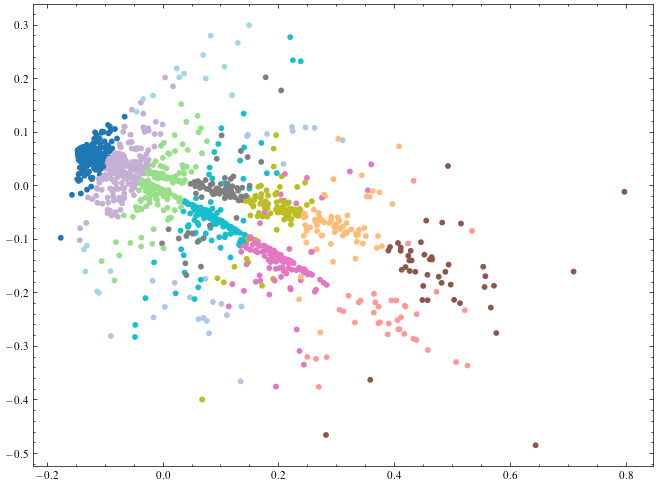


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.18666666139014113 (baseline: -0.0030344684802323064)
adjusted_rand_score: 0.05486004104828758 (baseline: -0.0003225681159114267)
completeness_score: 0.3995497152414326 (baseline: 0.2900964358351753)
entropy: 3.2064249166799192 (baseline: 4.594429072848464)
fowlkes_mallows_score: 0.10937598959285857 (baseline: 0.01433117108777137)
homogeneity_completeness_v_measure: (np.float64(0.3131044811538722), np.float64(0.3995497152414326), np.float64(0.3510841777642561)) (baseline: (np.float64(0.325740176654535), np.float64(0.2900964358351753), np.float64(0.3068868019190069)))
homogeneity_score: 0.3131044811538722 (baseline: 0.325740176654535)
mutual_info_score: 1.281126162402496 (baseline: 1.3328274987308484)
normalized_mutual_info_score: 0.3510841777642561 (baseline: 0.3068868019190069)
purity_score: 0.2088888888888889 (baseline: 0.12395061728395061)
rand_score: 0.9012487190748061 (baseline: 0.9686678377982726)
v_measure_scor

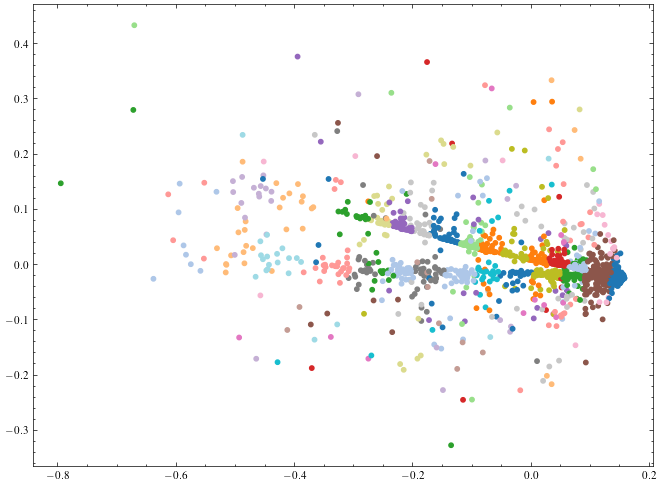


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.18946809568665654 (baseline: -0.002105363179200147)
adjusted_rand_score: 0.06424787930660657 (baseline: -0.00038294097356371675)
completeness_score: 0.482788118681226 (baseline: 0.4207971510864138)
entropy: 3.649558403102608 (baseline: 5.168317884064924)
fowlkes_mallows_score: 0.10575195282805096 (baseline: 0.00912783955898802)
homogeneity_completeness_v_measure: (np.float64(0.39113843203553034), np.float64(0.482788118681226), np.float64(0.4321575711173494)) (baseline: (np.float64(0.48278704448226684), np.float64(0.4207971510864138), np.float64(0.4496657066289424)))
homogeneity_score: 0.39113843203553034 (baseline: 0.48278704448226684)
mutual_info_score: 1.7619634354511675 (baseline: 2.1748134415234825)
normalized_mutual_info_score: 0.4321575711173495 (baseline: 0.4496657066289424)
purity_score: 0.24 (baseline: 0.14716049382716048)
rand_score: 0.9324759674035036 (baseline: 0.9779290489435417)
v_measure_score: 

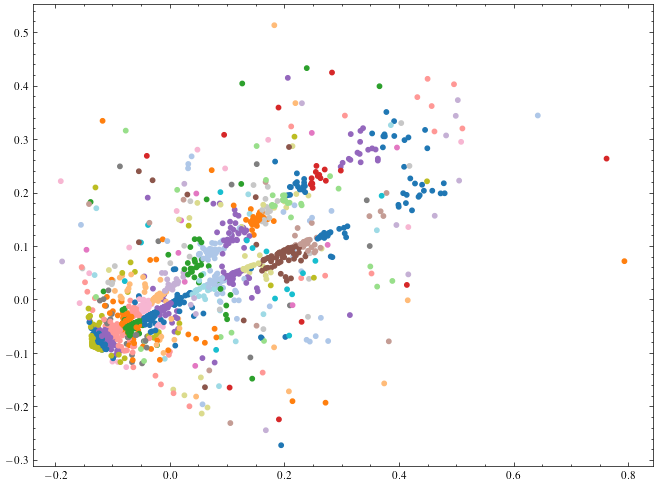

In [19]:
run_experiment(ts_12hour, subset_labels_12hour, label_maps, image_name="clusters_hour12")

In [20]:
ts_1day, subset_labels_1day = generate_timeseries_and_labels(unit_ids, 3600 * 24, 50, label_maps)

2025/2025



SUBSET ::: ('ISP',) :::
adjusted_mutual_info_score: 0.24676821684204198 (baseline: -0.001039814140157128)
adjusted_rand_score: 0.03420371043980455 (baseline: -5.482414782185257e-06)
completeness_score: 0.27255758509648087 (baseline: 0.00786508327496463)
entropy: 1.8074981015339857 (baseline: 2.298800481980326)
fowlkes_mallows_score: 0.21576642423207568 (baseline: 0.12775191344904416)
homogeneity_completeness_v_measure: (np.float64(0.23955621981864927), np.float64(0.27255758509648087), np.float64(0.25499357424833885)) (baseline: (np.float64(0.008791762217813096), np.float64(0.00786508327496463), np.float64(0.008302645540750163)))
homogeneity_score: 0.23955621981864927 (baseline: 0.008791762217813096)
mutual_info_score: 0.49264731762057695 (baseline: 0.01808025722330409)
normalized_mutual_info_score: 0.25499357424833885 (baseline: 0.008302645540750163)
purity_score: 0.36 (baseline: 0.31012345679012343)
rand_score: 0.70187722636998 (baseline: 0.7696340213731518)
v_measure_score: 0.254993

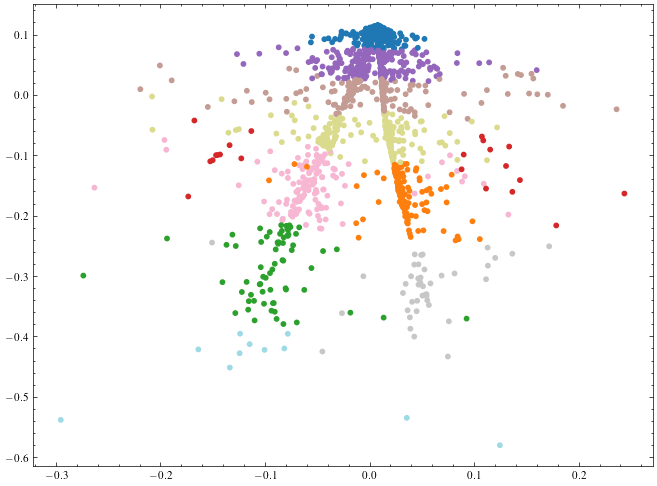


SUBSET ::: ('State',) :::
adjusted_mutual_info_score: 0.12470291235398795 (baseline: -0.00044774439286053406)
adjusted_rand_score: 0.049776357543474495 (baseline: 3.6735299712248265e-05)
completeness_score: 0.23714833418954767 (baseline: 0.1246136823197775)
entropy: 2.853678407073935 (baseline: 3.838452359628259)
fowlkes_mallows_score: 0.116274938411858 (baseline: 0.029115652099911998)
homogeneity_completeness_v_measure: (np.float64(0.19701502113955108), np.float64(0.23714833418954767), np.float64(0.21522675048495343)) (baseline: (np.float64(0.1392502926357495), np.float64(0.1246136823197775), np.float64(0.13152603899317458)))
homogeneity_score: 0.19701502113955108 (baseline: 0.1392502926357495)
mutual_info_score: 0.6767450805502656 (baseline: 0.4783236829423162)
normalized_mutual_info_score: 0.21522675048495343 (baseline: 0.13152603899317455)
purity_score: 0.18814814814814815 (baseline: 0.12197530864197531)
rand_score: 0.8722305177377642 (baseline: 0.9407002391060362)
v_measure_score

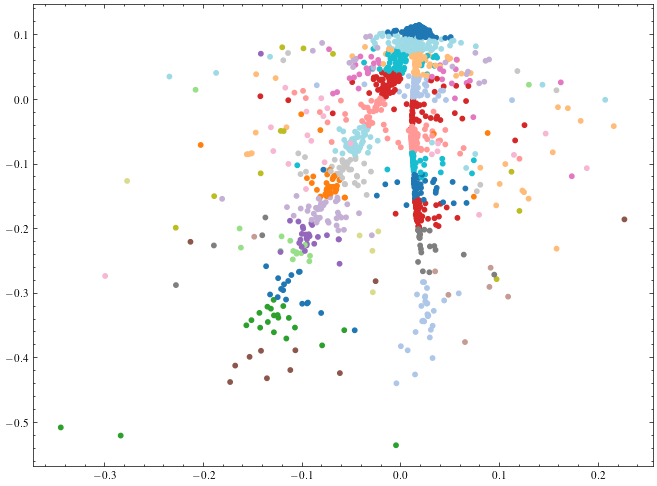


SUBSET ::: ('Technology',) :::
adjusted_mutual_info_score: 0.27877619798442155 (baseline: -3.4156017997726325e-05)
adjusted_rand_score: 0.045825542217675576 (baseline: -0.00013707097795638868)
completeness_score: 0.3038507426870589 (baseline: 0.0008687106243328132)
entropy: 0.81810653710254 (baseline: 1.098602771374402)
fowlkes_mallows_score: 0.4923203321961694 (baseline: 0.37566535673471585)
homogeneity_completeness_v_measure: (np.float64(0.2589008230859605), np.float64(0.3038507426870589), np.float64(0.27958058994966756)) (baseline: (np.float64(0.0009939833031655462), np.float64(0.0008687106243328132), np.float64(0.0009271344509390356)))
homogeneity_score: 0.2589008230859605 (baseline: 0.0009939833031655462)
mutual_info_score: 0.24858227889574472 (baseline: 0.0009543678994144156)
normalized_mutual_info_score: 0.27958058994966756 (baseline: 0.0009271344509390356)
purity_score: 0.6271604938271605 (baseline: 0.5624691358024692)
rand_score: 0.5205997169765286 (baseline: 0.52532425706338

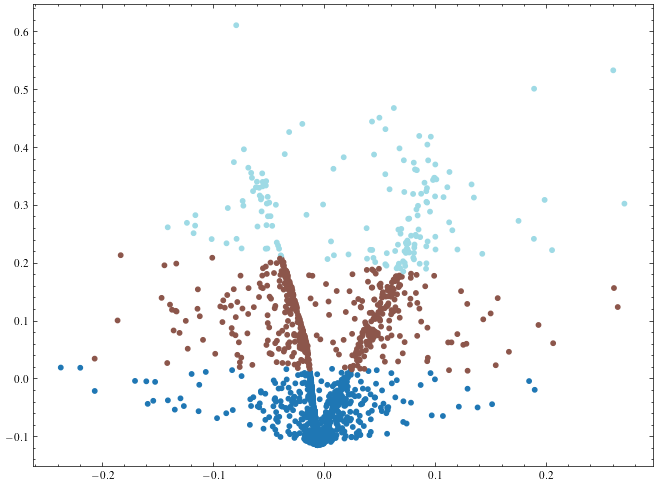


SUBSET ::: ('ISP', 'State') :::
adjusted_mutual_info_score: 0.17060353527787558 (baseline: 0.001791197623292998)
adjusted_rand_score: 0.05372574484172204 (baseline: 0.000507179282462903)
completeness_score: 0.46483362584956894 (baseline: 0.40961259670561745)
entropy: 3.594449076104215 (baseline: 5.136533511414699)
fowlkes_mallows_score: 0.09996995611913079 (baseline: 0.01087419496881776)
homogeneity_completeness_v_measure: (np.float64(0.37639976237540845), np.float64(0.46483362584956894), np.float64(0.415968431027337)) (baseline: (np.float64(0.4739831446695761), np.float64(0.40961259670561745), np.float64(0.4394531516881981)))
homogeneity_score: 0.37639976237540845 (baseline: 0.4739831446695761)
mutual_info_score: 1.6708207969771554 (baseline: 2.1039888296759983)
normalized_mutual_info_score: 0.415968431027337 (baseline: 0.43945315168819815)
purity_score: 0.23851851851851852 (baseline: 0.16)
rand_score: 0.9186258722490607 (baseline: 0.9757800224466892)
v_measure_score: 0.4159684310273

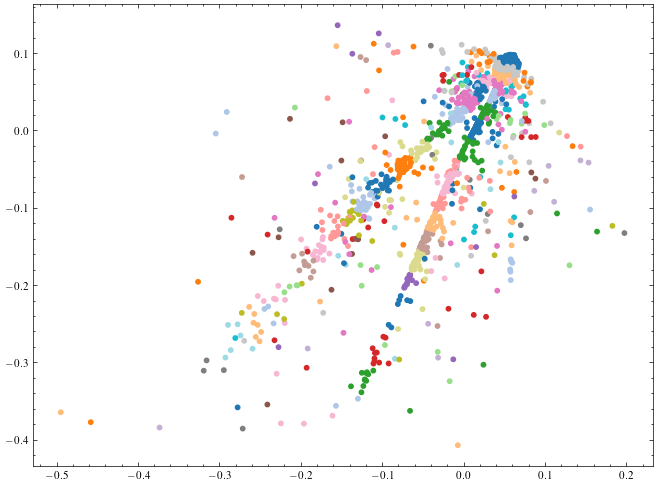


SUBSET ::: ('ISP', 'Technology') :::
adjusted_mutual_info_score: 0.28118276698608874 (baseline: 0.0010287895631056502)
adjusted_rand_score: 0.03145206079579927 (baseline: 0.00015146298013413495)
completeness_score: 0.31085769382409406 (baseline: 0.013334143749868226)
entropy: 1.9120096978167167 (baseline: 2.4827638989643557)
fowlkes_mallows_score: 0.20705385616432054 (baseline: 0.1144070879344689)
homogeneity_completeness_v_measure: (np.float64(0.2754499497265183), np.float64(0.31085769382409406), np.float64(0.29208466605486644)) (baseline: (np.float64(0.01534233779893896), np.float64(0.013334143749868226), np.float64(0.014267924558450475)))
homogeneity_score: 0.2754499497265183 (baseline: 0.01534233779893896)
mutual_info_score: 0.5943629252326075 (baseline: 0.03310553072577403)
normalized_mutual_info_score: 0.2920846660548664 (baseline: 0.014267924558450476)
purity_score: 0.374320987654321 (baseline: 0.31012345679012343)
rand_score: 0.709290489435417 (baseline: 0.7860513346020592)
v_

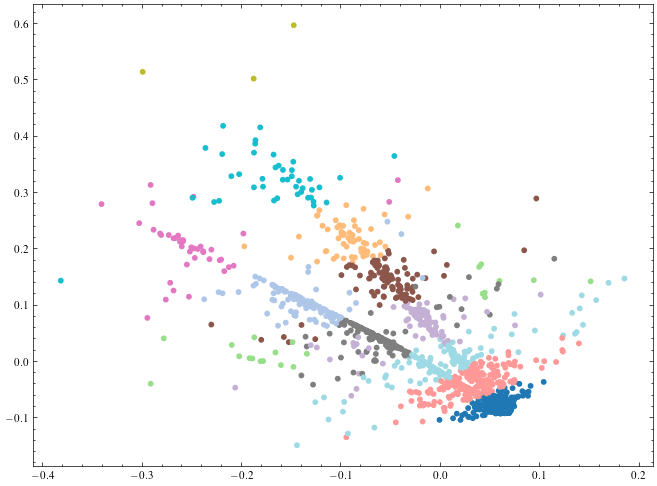


SUBSET ::: ('State', 'Technology') :::
adjusted_mutual_info_score: 0.20403710993853544 (baseline: -0.0028597207134746657)
adjusted_rand_score: 0.06514574289151785 (baseline: -0.0005656749914605972)
completeness_score: 0.4093877271654874 (baseline: 0.28973731463458985)
entropy: 3.3291474334452884 (baseline: 4.586655431567083)
fowlkes_mallows_score: 0.11300811463877224 (baseline: 0.014187650825945678)
homogeneity_completeness_v_measure: (np.float64(0.33309278884532234), np.float64(0.4093877271654874), np.float64(0.3673203453021381)) (baseline: (np.float64(0.3247864700479586), np.float64(0.28973731463458985), np.float64(0.3062623840018004)))
homogeneity_score: 0.33309278884532234 (baseline: 0.3247864700479586)
mutual_info_score: 1.3629121011769822 (baseline: 1.3289252278964023)
normalized_mutual_info_score: 0.36732034530213803 (baseline: 0.30626238400180034)
purity_score: 0.21530864197530863 (baseline: 0.12098765432098765)
rand_score: 0.9170014151173571 (baseline: 0.9685136388034938)
v_m

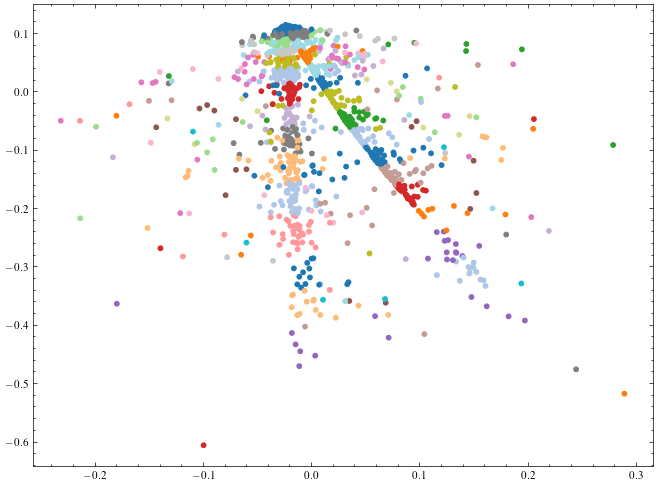


SUBSET ::: ('ISP', 'State', 'Technology') :::
adjusted_mutual_info_score: 0.180737979315796 (baseline: 0.0016696635484383575)
adjusted_rand_score: 0.05805393656628463 (baseline: 0.00017494787447296277)
completeness_score: 0.4833744088045534 (baseline: 0.4225902842274341)
entropy: 3.615973778457221 (baseline: 5.166583647506708)
fowlkes_mallows_score: 0.10557811555431917 (baseline: 0.00978069530969872)
homogeneity_completeness_v_measure: (np.float64(0.3880096485620185), np.float64(0.4833744088045534), np.float64(0.43047364224435997)) (baseline: (np.float64(0.48468164349934756), np.float64(0.4225902842274341), np.float64(0.45151127732873)))
homogeneity_score: 0.3880096485620185 (baseline: 0.48468164349934756)
mutual_info_score: 1.7478691874145262 (baseline: 2.183348052084673)
normalized_mutual_info_score: 0.43047364224435986 (baseline: 0.45151127732873)
purity_score: 0.2414814814814815 (baseline: 0.1506172839506173)
rand_score: 0.9207866100619724 (baseline: 0.9779305128580491)
v_measure_

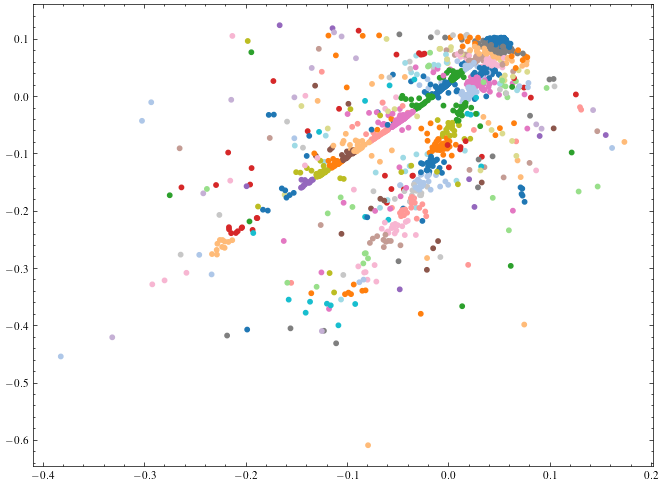

In [21]:
run_experiment(ts_1day, subset_labels_1day, label_maps, image_name="clusters_day1")